# Predicting Inflation Rate 

### AR（1）

### Lasso
*  1 month ahead
*  3 month ahead
*  12 month ahead

### Random Forest
*  1 month ahead
*  3 month ahead
*  12 month ahead

### Gradient Boosting
*  1 month ahead
*  3 month ahead
*  12 month ahead

# AR（1）
## Data preparation and modeling

### Load the required packages

In [48]:
# 加载需要的包
if (!requireNamespace("readxl", quietly = TRUE)) {
  install.packages("readxl")
}
library(readxl)

if (!requireNamespace("xts", quietly = TRUE)) {
  install.packages("xts")
}
library(xts)

if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}
library(dplyr)

if (!requireNamespace("forecast", quietly = TRUE)) {
  install.packages("forecast")
}
library(forecast)

# 安装并加载需要的包
if (!requireNamespace("tseries", quietly = TRUE)) {
  install.packages("tseries")
}
library(tseries)

### Processing data

In [49]:
#处理数据
data <- read_excel("/kaggle/input/train-data/US_PCE_training.xlsx")

##处理数据
data <- na.omit(data)

# 转化成长数据
data_transposed <- t(data)

# 将转置的矩阵转换为数据框
data_transposed <- as.data.frame(data_transposed)

# 设置新的列名
colnames(data_transposed) <- data_transposed[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
data_transposed <- data_transposed[-1, ]
# 重新排序列，使第二列成为第一列
data_transposed <- data_transposed[c(2, 1, 3:ncol(data_transposed))]

# 转换所有列为数值类型
data_transposed[] <- lapply(data_transposed, function(x) as.numeric(as.character(x)))



data_transposed$inflation_rate <- (log(data_transposed$`Personal consumption expenditures`) -
                              log(lag(data_transposed$`Personal consumption expenditures`))) * 12

inflation_ts <- ts(data_transposed$inflation_rate, frequency = 12)  # Assuming monthly data with annual frequency

inflation_ts <- na.omit(inflation_ts)


### Testing the stationarity of the inflation rate

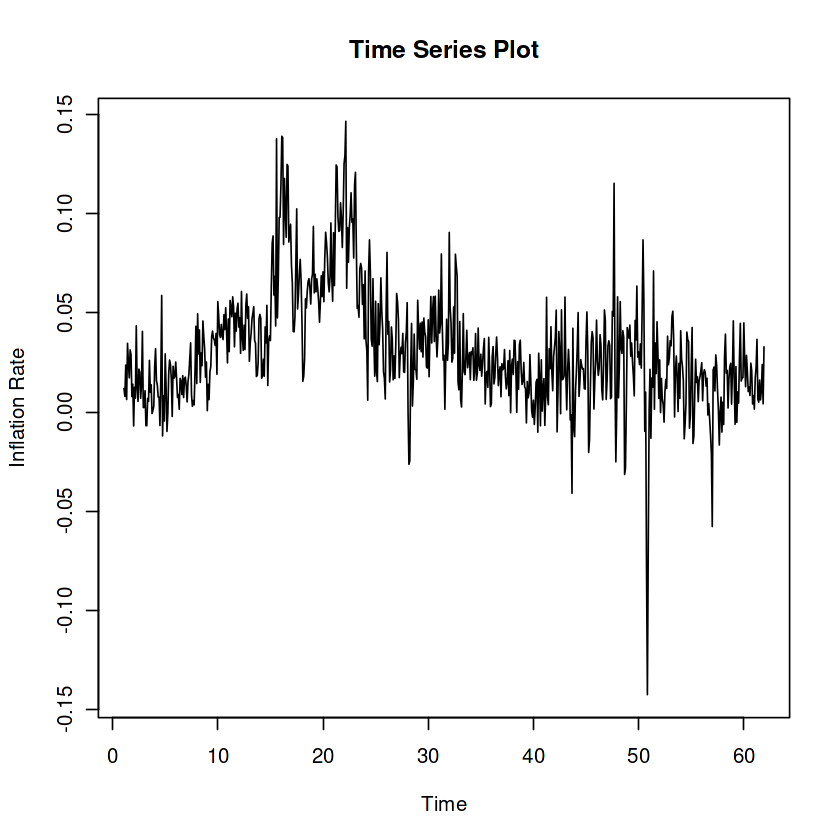


	Augmented Dickey-Fuller Test

data:  inflation_ts
Dickey-Fuller = -3.2955, Lag order = 9, p-value = 0.07147
alternative hypothesis: stationary


Warning message in kpss.test(inflation_ts):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  inflation_ts
KPSS Level = 2.5192, Truncation lag parameter = 6, p-value = 0.01


Warning message in pp.test(inflation_ts):
“p-value smaller than printed p-value”



	Phillips-Perron Unit Root Test

data:  inflation_ts
Dickey-Fuller Z(alpha) = -233.9, Truncation lag parameter = 6, p-value
= 0.01
alternative hypothesis: stationary


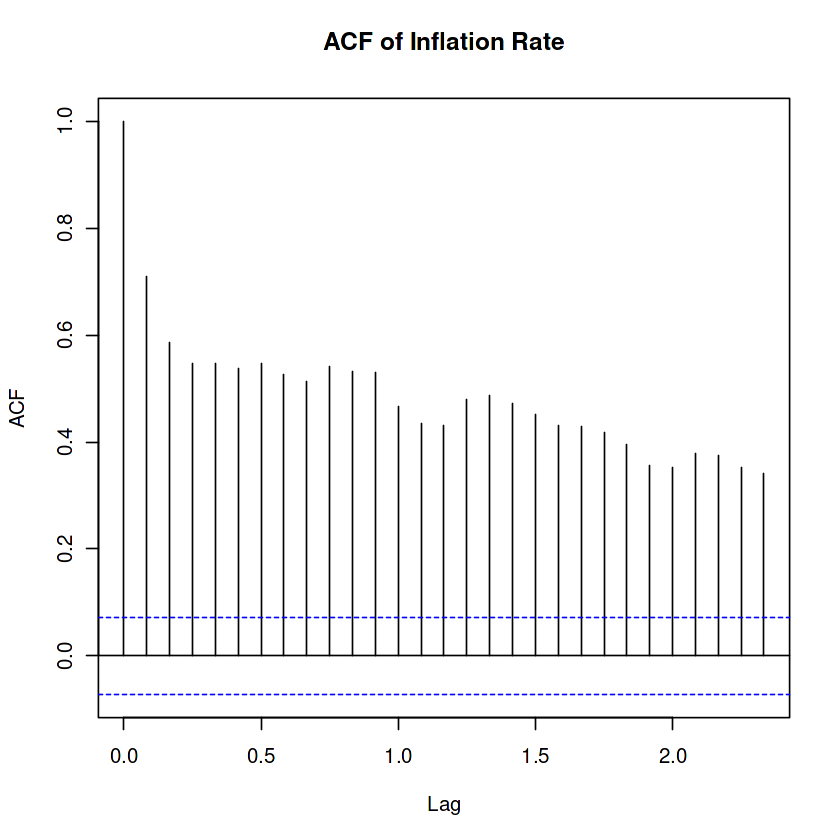

In [37]:
#检验inflation rate的平稳性
# 检验原始数据的平稳性1
plot(inflation_ts , main="Time Series Plot", xlab="Time", ylab="Inflation Rate")

# 检验原始数据的平稳性2
acf(inflation_ts , main="ACF of Inflation Rate")

#检验原始数据的平稳性3

# 进行ADF检验
adf.test(inflation_ts, alternative = "stationary")

# 进行KPSS检验
kpss.test(inflation_ts)

# 使用PP检验
pp.test(inflation_ts)



Unit Root Tests Results:

Augmented Dickey-Fuller (ADF) Test: The test yields a p-value of 0.07147, which at a conventional significance level (e.g., 0.05), suggests that we fail to reject the null hypothesis of a unit root, indicating non-stationarity.

KPSS Test: This test checks for level stationarity and results in a p-value of 0.01, leading to rejection of the null hypothesis of stationarity, further supporting the indication of non-stationarity.

Phillips-Perron Test: Similar to the ADF test, this test gives a very low p-value (the exact number is not visible), suggesting rejection of the unit root, which would indicate stationarity. However, this conflicts slightly with the ADF test's result.

ACF Plot of Inflation Rate:

The Autocorrelation Function (ACF) plot shows significant autocorrelation at various lags, which does not quickly decay, suggesting a non-stationary process since stationary processes usually have autocorrelations that quickly drop to zero.


#### To summarize, we should do a first-order difference on the inflation Rate before AR(1)

Warning message in adf.test(diff_inflation_ts, alternative = "stationary"):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_inflation_ts
Dickey-Fuller = -14.42, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary



Warning message in kpss.test(diff_inflation_ts):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  diff_inflation_ts
KPSS Level = 0.012789, Truncation lag parameter = 6, p-value = 0.1



Warning message in pp.test(diff_inflation_ts):
“p-value smaller than printed p-value”



	Phillips-Perron Unit Root Test

data:  diff_inflation_ts
Dickey-Fuller Z(alpha) = -715.97, Truncation lag parameter = 6, p-value
= 0.01
alternative hypothesis: stationary



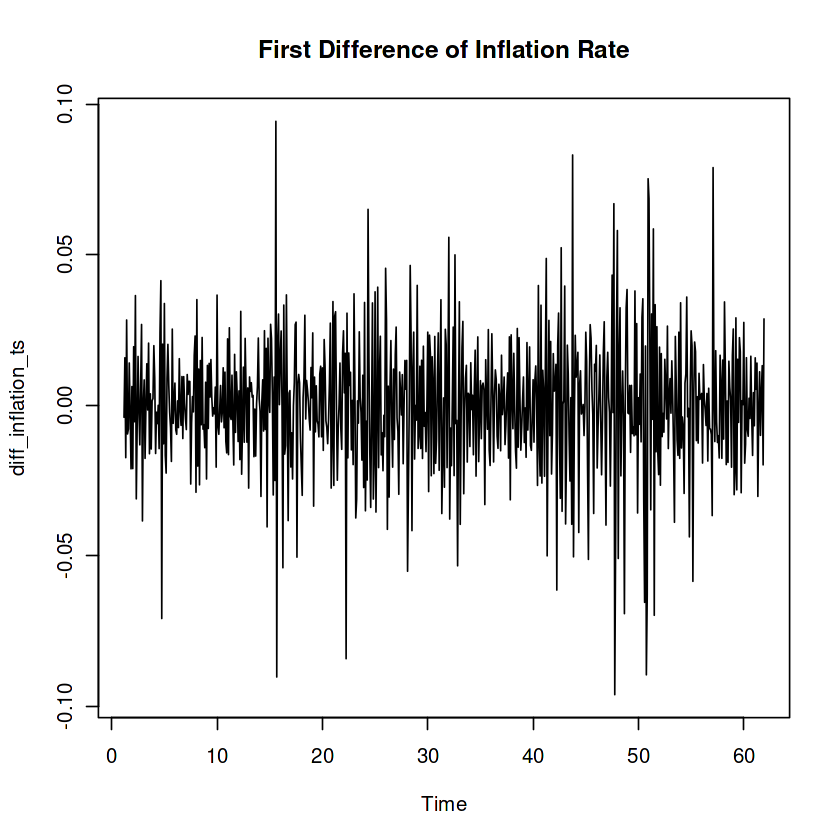

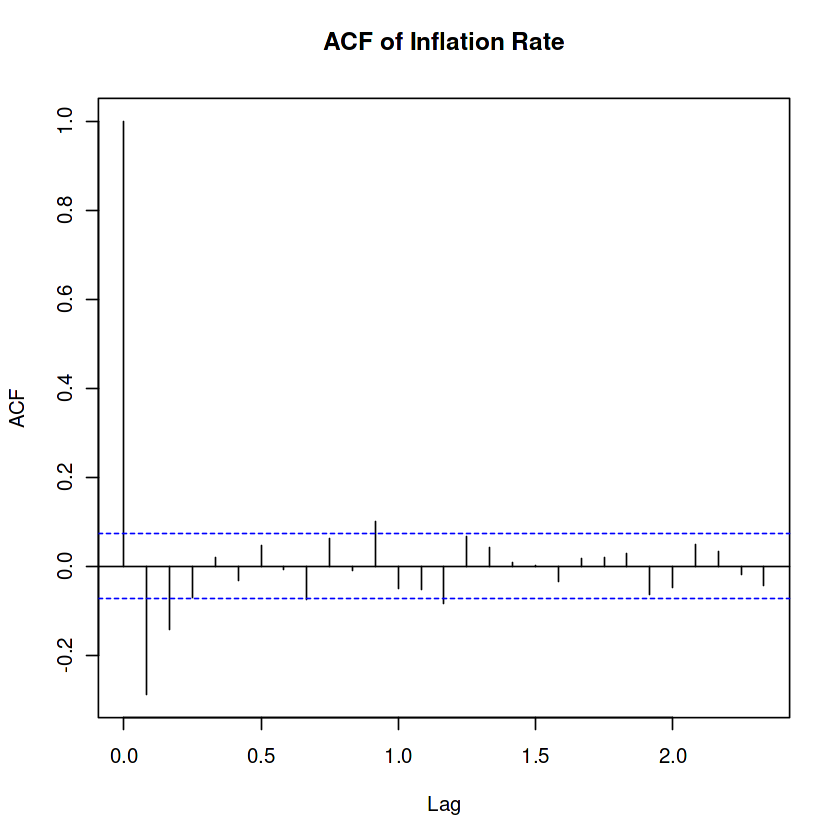

In [38]:
# 一阶差分
diff_inflation_ts <- diff(inflation_ts, differences = 1)


diff_inflation_ts <- na.omit(diff_inflation_ts)
# 检查差分后的数据
plot(diff_inflation_ts, main="First Difference of Inflation Rate")


# ADF测试
adf_result_diff <- adf.test(diff_inflation_ts, alternative = "stationary")
print(adf_result_diff)

# KPSS测试
kpss_result_diff <- kpss.test(diff_inflation_ts)
print(kpss_result_diff)

# PP测试
pp_result_diff <- pp.test(diff_inflation_ts)
print(pp_result_diff)

#检验原始数据的平稳性
acf(diff_inflation_ts, main="ACF of Inflation Rate")

#### The above validation shows that the differential Inflation Rate is stationary

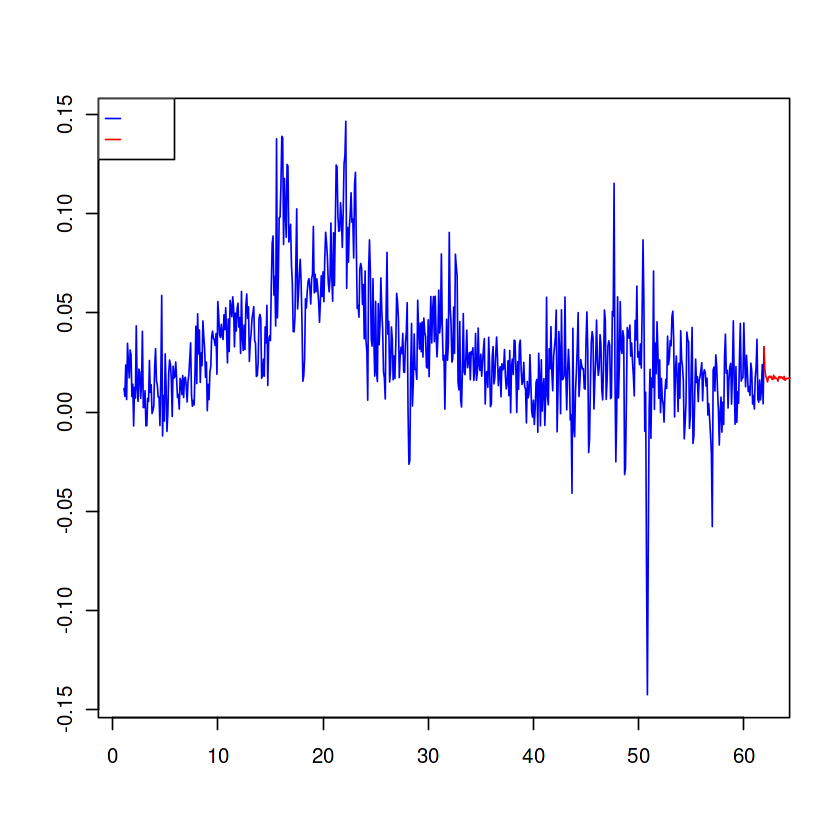

In [39]:

# 拟合ARIMA模型
library(forecast)
model_arima <- auto.arima(diff_inflation_ts)

# 预测未来50个月
forecast_diff <- forecast(model_arima, h=50)

# 逆向差分
last_original_value <- tail(inflation_ts, n=1)  # 取原始序列的最后一个值

# 初始化预测结果数组，长度等于预测月份+1，第一个元素为最后一个实际值
forecast_original <- numeric(length = length(forecast_diff$mean) + 1)
forecast_original[1] <- last_original_value

# 通过逐步累加预测的差分恢复原始尺度的预测值
for (i in 2:length(forecast_original)) {
  forecast_original[i] <- forecast_original[i - 1] + forecast_diff$mean[i - 1]
}

# 绘图
time_original <- time(inflation_ts)
time_forecast <- seq(max(time_original), by = 1/12, length.out = length(forecast_original))

# 绘制图像
plot(time_original, inflation_ts, type = 'l', col = 'blue', xlab = '时间', ylab = '通胀率', main = '通胀率及其预测')
lines(time_forecast, forecast_original, col = 'red')
legend("topleft", legend = c("原始通胀率", "预测通胀率"), col = c("blue", "red"), lty = 1, cex = 0.8)


## Evaluation of AR (1)

[1] "MSE： 32.1391569459003"


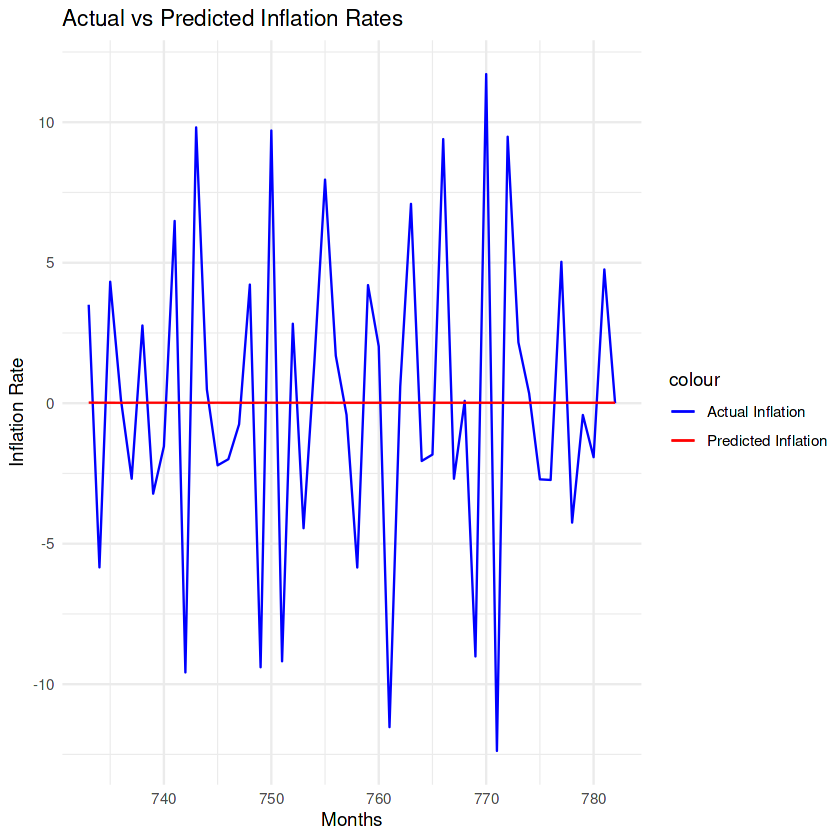

In [40]:
#比较AR（1）模型

testing_data <- read_excel("/kaggle/input/fake-data/US_PCE_testing_fake.xlsx")
##处理数据
testing_data <- na.omit(testing_data)

# 转化成长数据
testing_data <- t(testing_data)

# 将转置的矩阵转换为数据框
testing_data <- as.data.frame(testing_data)

# 设置新的列名
colnames(testing_data) <- testing_data[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
testing_data <- testing_data[-1, ]
# 重新排序列，使第二列成为第一列
testing_data <- testing_data[c(2, 1, 3:ncol(testing_data))]

# 转换所有列为数值类型
testing_data[] <- lapply(testing_data, function(x) as.numeric(as.character(x)))

data_transposed <- data_transposed[,-207]
data_transposed_test <- rbind(data_transposed, testing_data)

data_transposed_test$inflation_rate <- (log(data_transposed_test$`Personal consumption expenditures`) -
                                     log(lag(data_transposed_test$`Personal consumption expenditures`))) * 12

# 提取Y_test的后50行作为新的目标数据

Future_data<- data_transposed_test[(nrow(data_transposed_test)-49):nrow(data_transposed_test),]
# 保留Future_data的第一列和最后一列
Future_data<- Future_data[, c(1, ncol(Future_data))]


# 使用预测的时间和对应的预测值创建数据框
forecast_df <- data.frame(
  Time = time_forecast,
  Predicted_Inflation_Rate = forecast_original
)
# 删除forecast_df的第一行
forecast_df <- forecast_df[-1, ]
# 重命名列
names(forecast_df)[names(forecast_df) == "Time"] <- "month"
# 设置第一行的值为733，后续递增
forecast_df$month <- 733 + (0:(nrow(forecast_df) - 1))

# 假设 Future_data 中的时间列也命名为 'months'，并且有一个名为 'Actual_Inflation' 的列
# 合并数据框
combined_data <- merge(forecast_df, Future_data, by = "month", all = TRUE)

# 重命名列以区分预测和实际值

names(combined_data)[names(combined_data) == "inflation_rate"] <- "Actual_Inflation_Rate"

library(ggplot2)

# 绘制图形
ggplot(data = combined_data, aes(x = month)) +
  geom_line(aes(y = Actual_Inflation_Rate, colour = "Actual Inflation")) +
  geom_line(aes(y = Predicted_Inflation_Rate, colour = "Predicted Inflation")) +
  scale_colour_manual(values = c("Actual Inflation" = "blue", "Predicted Inflation" = "red")) +
  labs(title = "Actual vs Predicted Inflation Rates", x = "Months", y = "Inflation Rate") +
  theme_minimal()

mse_AR <- mean((combined_data$Actual_Inflation_Rate -  combined_data$Predicted_Inflation_Rate)^2)
print(paste("MSE：", mse_AR))


# Lasso（1 months ahead）
## Data preparation and modeling

### Processing data

In [50]:
data <- read_excel("/kaggle/input/train-data/US_PCE_training.xlsx")

##处理数据
data <- na.omit(data)

# 转化成长数据
data_transposed <- t(data)

# 将转置的矩阵转换为数据框
data_transposed <- as.data.frame(data_transposed)

# 设置新的列名
colnames(data_transposed) <- data_transposed[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
data_transposed <- data_transposed[-1, ]
# 重新排序列，使第二列成为第一列
data_transposed <- data_transposed[c(2, 1, 3:ncol(data_transposed))]

# 转换所有列为数值类型
data_transposed[] <- lapply(data_transposed, function(x) as.numeric(as.character(x)))


#构造inflation rate



Newdata <- data_transposed


Newdata <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~ (log(.) - log(lag(.))) * 12,
    .names = "{.col}_log_diff_12"
  ))

#将inflation rate移动数据第一列
# 假设 data_transformed 是包含我们之前计算得到的列的数据框
# 首先重命名列
Newdata <- Newdata %>%
  rename('inflation rate' = 'Personal consumption expenditures_log_diff_12')

# 然后将重命名的列移动到第一列位置
Newdata <- Newdata %>%
  relocate(`inflation rate`, .before = 1)


#为每列变量生成24月的滞后项
# 首先生成滞后变量并添加到临时数据框中
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = list(lag1 = ~lag(., 1), lag2 = ~lag(., 2), lag3 = ~lag(., 3),
                lag4 = ~lag(., 4), lag5 = ~lag(., 5), lag6 = ~lag(., 6),
                lag7 = ~lag(., 7), lag8 = ~lag(., 8), lag9 = ~lag(., 9),
                lag10 = ~lag(., 10), lag11 = ~lag(., 11), lag12 = ~lag(., 12),
                lag13 = ~lag(., 13), lag14 = ~lag(., 14), lag15 = ~lag(., 15),
                lag16 = ~lag(., 16), lag17 = ~lag(., 17), lag18 = ~lag(., 18),
                lag19 = ~lag(., 19), lag20 = ~lag(., 20), lag21 = ~lag(., 21),
                lag22 = ~lag(., 22), lag23 = ~lag(., 23), lag24 = ~lag(., 24)),
    .names = "{.col}_{.fn}"
  ))

# 从临时数据框中选择所有生成的滞后变量列，创建一个新的数据框
data_transposed_lag <- temp_data %>%
  select(matches("lag(1[0-9]|2[0-4]|[1-9])$"))



#创建前三个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后一个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3 <- temp_data %>%
  select(ends_with("_rollmean3"))

#创建前六个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6 <- temp_data %>%
  select(ends_with("_rollmean6"))




#创建前12个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12 <- temp_data %>%
  select(ends_with("_rollmean12"))


#创建前24个月的平均值
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24 <- temp_data %>%
  select(ends_with("_rollmean24"))



#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined <- bind_cols(Newdata, data_rollmean3, data_rollmean6, 
                               data_rollmean12, data_rollmean24, data_transposed_lag)

all_data_combined <- all_data_combined %>%
  select(-c(3:411))


all_data_combined <- na.omit(all_data_combined)

#标准化X
X <- all_data_combined[,-(1:2)]

X_scaled <- scale(X)

Y <- all_data_combined[,1]

X_scaled <- as.matrix(X_scaled)

### Modeling

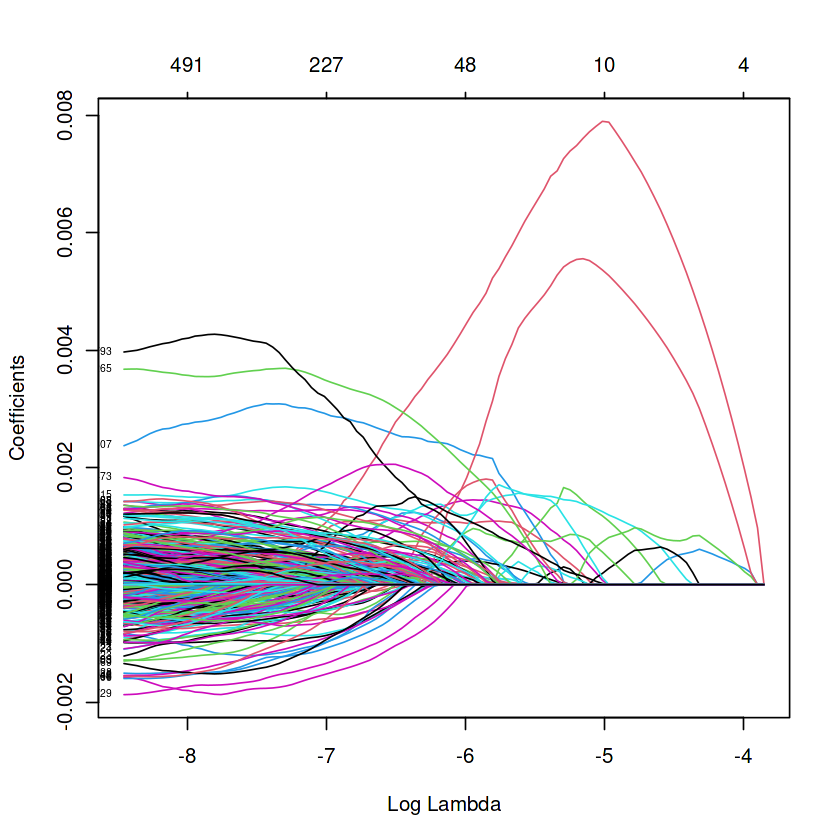

[1] 233


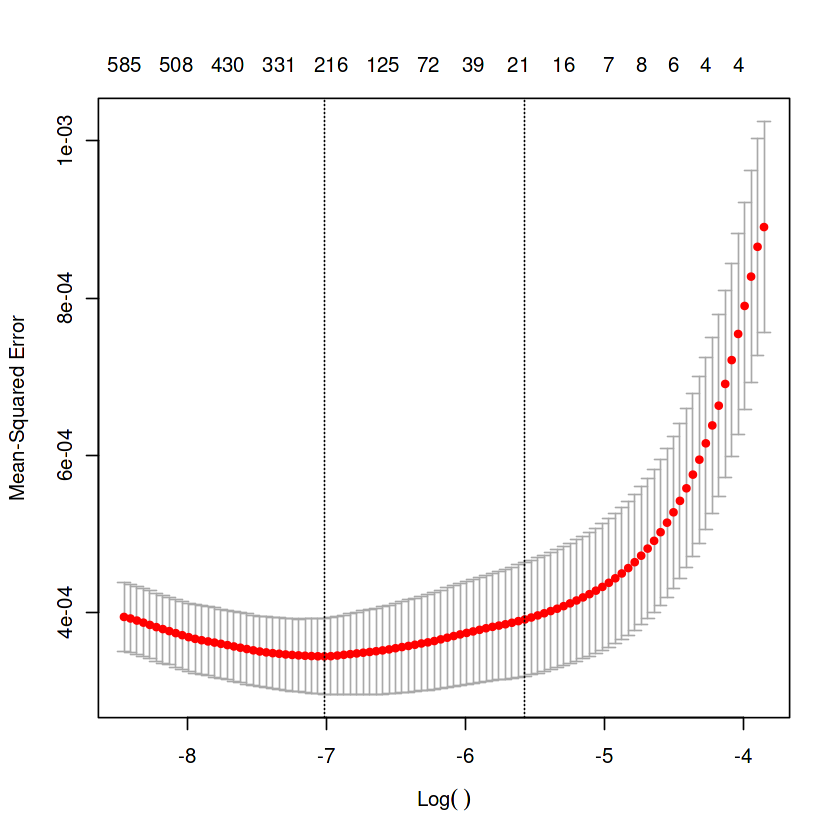

In [51]:
# 安装和加载glmnet包
if (!require(glmnet)) {
  install.packages("glmnet", dependencies = TRUE)
  library(glmnet)
}

# 假设Y已经存在于你的环境中，并且与X_scaled的行数相同
# 拟合LASSO回归模型1
# 利用信息到提前1月，前24个月的数据预测
set.seed(123)
lasso_model <- glmnet(X_scaled, Y, family = "gaussian", alpha = 1)

# 可视化系数路径
plot(lasso_model, xvar = "lambda", label = TRUE)

# 进行交叉验证
cv_lasso <- cv.glmnet(X_scaled, Y, family = "gaussian", alpha = 1)
# 绘制交叉验证结果
plot(cv_lasso)

# 最佳lambda
best_lambda <- cv_lasso$lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model <- glmnet(X_scaled, Y, family = "gaussian", alpha = 1, lambda = best_lambda)



# 获取模型系数
coefficients_best <- coef(best_lasso_model, s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count <- sum(coefficients_best != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count)

In [52]:
# 储存模型
# 保存LASSO模型到磁盘
saveRDS(best_lasso_model, "best_lasso_model.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'best_lasso_model.rds'.\n")


LASSO model saved successfully to 'best_lasso_model.rds'.


# Lasso（3 months ahead）
## Data preparation and modeling
### Processing data

In [53]:
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_3months  <- data_transposed_lag %>%
  select(-matches(".*_lag[12]$"))

#3个月平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_3months <- temp_data %>%
  select(ends_with("_rollmean3"))

##创建前六个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_3months  <- temp_data %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_3months  <- temp_data %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_3months  <- temp_data %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_3months <- bind_cols(Newdata, data_rollmean3_3months, data_rollmean6_3months, 
                               data_rollmean12_3months, data_rollmean24_3months, data_transposed_lag_3months)

all_data_combined_3months <- all_data_combined_3months %>%
  select(-c(3:411))


all_data_combined_3months  <- na.omit(all_data_combined_3months )

#标准化X
X_3months <- all_data_combined_3months[,-(1:2)]

X_scaled_3months <- scale(X_3months)

Y_3months <- all_data_combined_3months[,1]

X_scaled_3months <- as.matrix(X_scaled_3months)

### Modeling

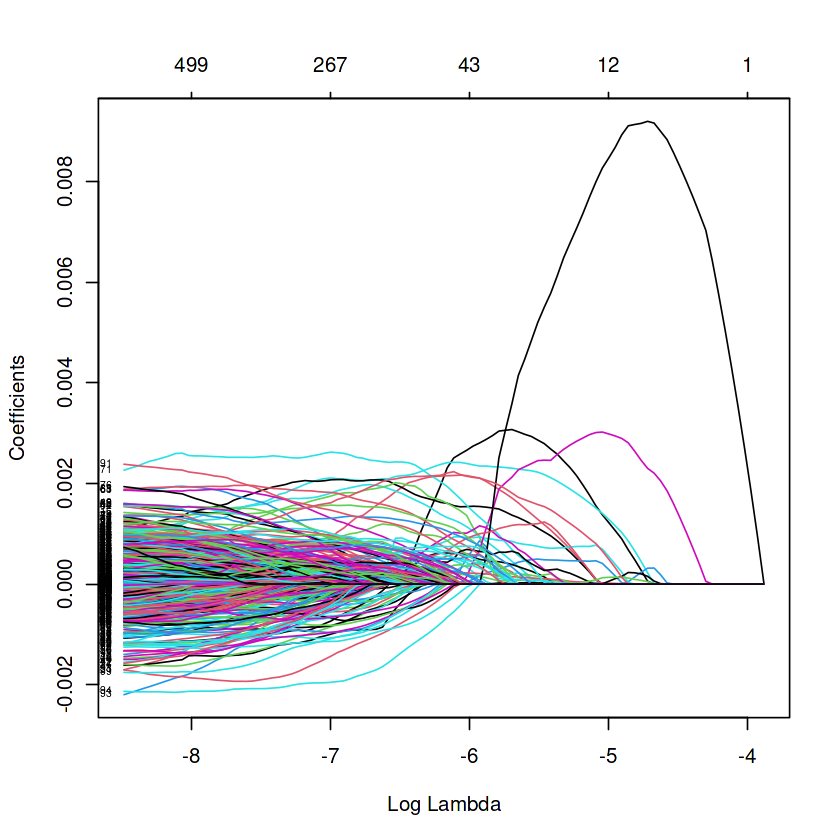

[1] 113


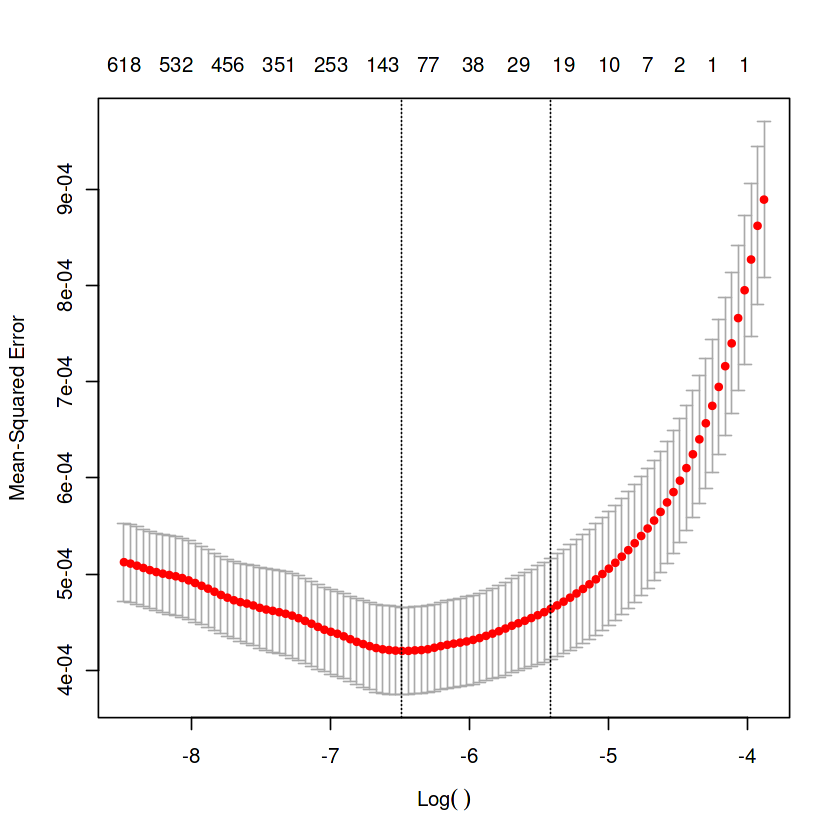

In [54]:
# 利用信息到提前3月，前24个月的数据预测
set.seed(123)
lasso_model_3months <- glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1)

# 可视化系数路径
plot(lasso_model_3months, xvar = "lambda", label = TRUE)

# 进行交叉验证
cv_lasso_3months <- cv.glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1)
# 绘制交叉验证结果
plot(cv_lasso_3months)

# 最佳lambda
best_lambda_3months <- cv_lasso_3months$lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model_3months <- glmnet(X_scaled_3months, Y_3months, family = "gaussian", alpha = 1, lambda = best_lambda_3months)


# 获取模型系数
coefficients_best_3months <- coef(best_lasso_model_3months, s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count_3months <- sum(coefficients_best_3months != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count_3months)


In [55]:
# 储存模型
# 保存LASSO模型到磁盘
saveRDS(best_lasso_model_3months, "best_lasso_model_3months.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'best_lasso_model_3months.rds'.\n")

LASSO model saved successfully to 'best_lasso_model_3months.rds'.


# Lasso（1 year ahead）
## Data preparation and modeling
### Processing data

In [56]:
# 利用信息到提前12月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_12months  <- data_transposed_lag %>%
  select(-matches(".*_lag(1[01]|[1-9])$"))


#3个月平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后12个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后12个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_12months <- temp_data %>%
  select(ends_with("_rollmean3"))

##创建前六个月的平均值


# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean6_12months  = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_12months   <- temp_data %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean12_12months  = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_12months   <- temp_data %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data <- Newdata %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean24_12months  = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_12months  <- temp_data %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_12months  <- bind_cols(Newdata, data_rollmean3_12months , data_rollmean6_12months , 
                                       data_rollmean12_12months , data_rollmean24_12months , data_transposed_lag_12months )

all_data_combined_12months  <- all_data_combined_12months  %>%
  select(-c(3:411))


all_data_combined_12months   <- na.omit(all_data_combined_12months  )

#标准化X
X_12months  <- all_data_combined_12months [,-(1:2)]

X_scaled_12months  <- scale(X_12months )

Y_12months  <- all_data_combined_12months [,1]

X_scaled_12months  <- as.matrix(X_scaled_12months )


### Modeling

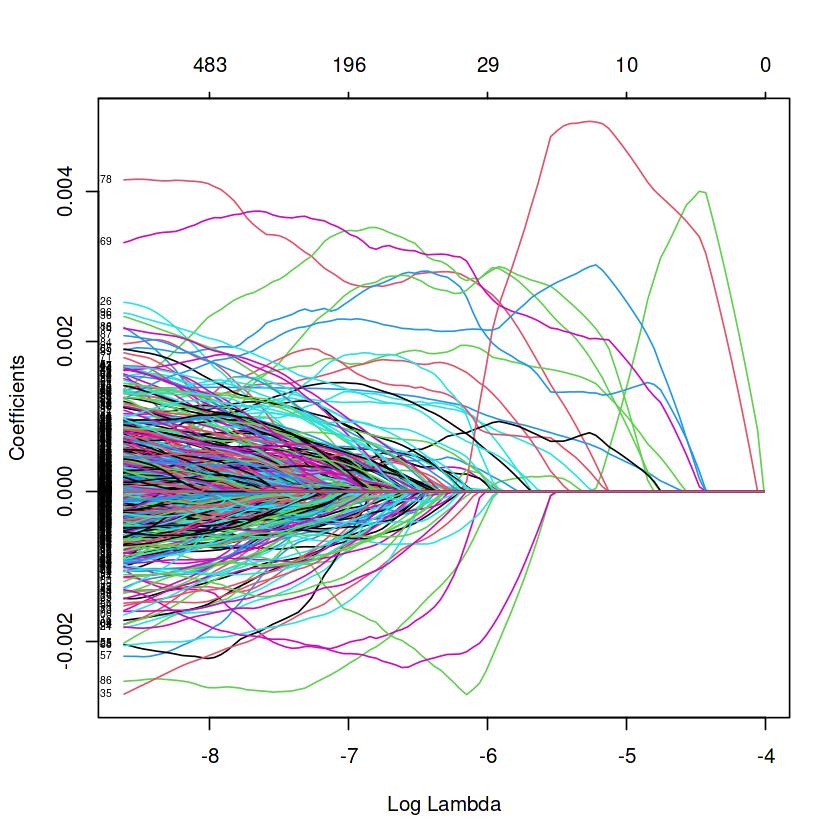

[1] 88


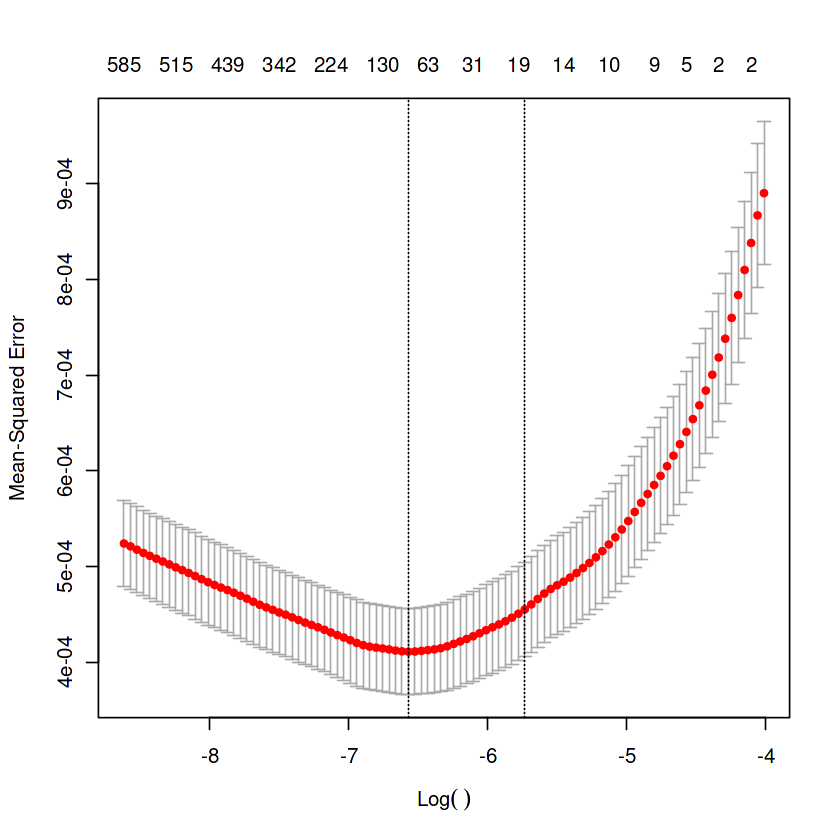

In [57]:
# 利用信息到提前12月，前24个月的数据预测
set.seed(123)
lasso_model_12months  <- glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1)

# 可视化系数路径
plot(lasso_model_12months , xvar = "lambda", label = TRUE)

# 进行交叉验证
cv_lasso_12months  <- cv.glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1)
# 绘制交叉验证结果
plot(cv_lasso_12months )

# 最佳lambda
best_lambda_12months  <- cv_lasso_12months $lambda.min
# 使用最佳lambda重新拟合模型
best_lasso_model_12months  <- glmnet(X_scaled_12months , Y_12months , family = "gaussian", alpha = 1, lambda = best_lambda_12months )



# 获取模型系数
coefficients_best_12months  <- coef(best_lasso_model_12months , s = "lambda.min")

# 计算非零系数的数量
non_zero_coeffs_count_12months <- sum(coefficients_best_12months != 0)

# 打印非零系数的数量
print(non_zero_coeffs_count_12months )


In [58]:
# 储存模型
# 保存LASSO模型到磁盘
saveRDS(best_lasso_model_12months, "best_lasso_model_12months.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'best_lasso_model_12months.rds'.\n")

LASSO model saved successfully to 'best_lasso_model_12months.rds'.


## Test data processing

In [59]:
#Test 数据处理V2
# 加载数据
testing_data <- read_excel("/kaggle/input/fake-data/US_PCE_testing_fake.xlsx")

##处理数据
testing_data <- na.omit(testing_data)

# 转化成长数据
testing_data <- t(testing_data)

# 将转置的矩阵转换为数据框
testing_data <- as.data.frame(testing_data)

# 设置新的列名
colnames(testing_data) <- testing_data[1, ]  # 将第一行的值设置为列名

# 删除现在作为列名的第一行
testing_data <- testing_data[-1, ]
# 重新排序列，使第二列成为第一列
testing_data <- testing_data[c(2, 1, 3:ncol(testing_data))]

# 转换所有列为数值类型
testing_data[] <- lapply(testing_data, function(x) as.numeric(as.character(x)))

data_transposed_test <- rbind(data_transposed, testing_data)

Newdata_test <- data_transposed_test

Newdata_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~ (log(.) - log(lag(.))) * 12,
    .names = "{.col}_log_diff_12"
  ))

Newdata_test <- Newdata_test %>%
  rename('inflation rate' = 'Personal consumption expenditures_log_diff_12')

# 然后将重命名的列移动到第一列位置
Newdata_test <- Newdata_test %>%
  relocate(`inflation rate`, .before = 1)

#为每列变量生成24月的滞后项
# 首先生成滞后变量并添加到临时数据框中
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = list(lag1 = ~lag(., 1), lag2 = ~lag(., 2), lag3 = ~lag(., 3),
                lag4 = ~lag(., 4), lag5 = ~lag(., 5), lag6 = ~lag(., 6),
                lag7 = ~lag(., 7), lag8 = ~lag(., 8), lag9 = ~lag(., 9),
                lag10 = ~lag(., 10), lag11 = ~lag(., 11), lag12 = ~lag(., 12),
                lag13 = ~lag(., 13), lag14 = ~lag(., 14), lag15 = ~lag(., 15),
                lag16 = ~lag(., 16), lag17 = ~lag(., 17), lag18 = ~lag(., 18),
                lag19 = ~lag(., 19), lag20 = ~lag(., 20), lag21 = ~lag(., 21),
                lag22 = ~lag(., 22), lag23 = ~lag(., 23), lag24 = ~lag(., 24)),
    .names = "{.col}_{.fn}"
  ))

# 从临时数据框中选择所有生成的滞后变量列，创建一个新的数据框
data_transposed_lag_test <- temp_data_test %>%
  select(matches("lag(1[0-9]|2[0-4]|[1-9])$"))



#创建前三个月的平均值
library(dplyr)
library(zoo)

# 创建临时数据框，先将所有变量延后一个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_test <- temp_data_test %>%
  select(ends_with("_rollmean3"))



#创建前六个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_test <- temp_data_test %>%
  select(ends_with("_rollmean6"))


#创建前12个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_test <- temp_data_test %>%
  select(ends_with("_rollmean12"))



#创建前24个月的平均值
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(.),  # 延后一个月
    .names = "{.col}_lag"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_test <- temp_data_test %>%
  select(ends_with("_rollmean24"))


#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_test <- bind_cols(Newdata_test, data_rollmean3_test, data_rollmean6_test, 
                               data_rollmean12_test, data_rollmean24_test, data_transposed_lag_test)

all_data_combined_test <- all_data_combined_test %>%
  select(-c(3:411))


all_data_combined_test <- na.omit(all_data_combined_test)

#标准化X
X_test <- all_data_combined_test[,-(1:2)]

X_scaled_test <- scale(X_test)

Y_test <- all_data_combined_test[,1]

X_scaled_test <- as.matrix(X_scaled_test)




### 数据整理2
# 利用信息到提前3月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_3months_test  <- data_transposed_lag_test %>%
  select(-matches(".*_lag[12]$"))

# 创建临时数据框，先将所有变量延后三个月
temp_data_test  <- Newdata_test  %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_3months_test  <- temp_data_test  %>%
  select(ends_with("_rollmean3"))



# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean6 = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean6"))

#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean12 = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean12"))

#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 3),  # 延后三个月
    .names = "{.col}_lag3"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag3"),  # 选择延后的列
    .fns = list(rollmean24 = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_3months_test  <- temp_data_test %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_3months_test  <- bind_cols(Newdata_test , data_rollmean3_3months_test , data_rollmean6_3months_test , 
                                       data_rollmean12_3months_test , data_rollmean24_3months_test , data_transposed_lag_3months_test )

all_data_combined_3months_test  <- all_data_combined_3months_test  %>%
  select(-c(3:411))


all_data_combined_3months_test   <- na.omit(all_data_combined_3months_test  )

#标准化X
X_3months_test  <- all_data_combined_3months_test [,-(1:2)]

X_scaled_3months_test  <- scale(X_3months_test )

Y_3months_test  <- all_data_combined_3months_test [,1]

X_scaled_3months_test  <- as.matrix(X_scaled_3months_test )

### 拟合LASSO回归模型3
# 利用信息到提前12月，前24个月的数据预测
# 从data_transposed_lag数据集中删除具有_lag1和_lag2尾缀的列
data_transposed_lag_12months_test   <- data_transposed_lag_test  %>%
  select(-matches(".*_lag(1[01]|[1-9])$"))

# 创建临时数据框，先将所有变量延后12个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后12个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean3 = ~rollmean(x = ., k = 3, fill = NA, align = "right")),
    .names = "{.col}_rollmean3"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean3_12months_test <- temp_data_test %>%
  select(ends_with("_rollmean3"))


# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean6_12months  = ~rollmean(x = ., k = 6, fill = NA, align = "right")),
    .names = "{.col}_rollmean6"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean6_12months_test   <- temp_data_test %>%
  select(ends_with("_rollmean6"))


#创建前12个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean12_12months  = ~rollmean(x = ., k = 12, fill = NA, align = "right")),
    .names = "{.col}_rollmean12"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean12_12months_test   <- temp_data_test %>%
  select(ends_with("_rollmean12"))




#创建前24个月的平均值
# 创建临时数据框，先将所有变量延后三个月
temp_data_test <- Newdata_test %>%
  mutate(across(
    .cols = -month,  # 排除月份列
    .fns = ~lag(., 12),  # 延后三个月
    .names = "{.col}_lag12"
  )) %>%
  # 计算延后数据的滚动平均值
  mutate(across(
    .cols = ends_with("_lag12"),  # 选择延后的列
    .fns = list(rollmean24_12months  = ~rollmean(x = ., k = 24, fill = NA, align = "right")),
    .names = "{.col}_rollmean24"
  ))

# 从临时数据框中选择所有生成的平均变量列，创建一个新的数据框
data_rollmean24_12months_test  <- temp_data_test %>%
  select(ends_with("_rollmean24"))

#合并特征
# 使用bind_cols直接横向合并所有数据框
all_data_combined_12months_test  <- bind_cols(Newdata_test, data_rollmean3_12months_test , data_rollmean6_12months_test , 
                                         data_rollmean12_12months_test , data_rollmean24_12months_test , data_transposed_lag_12months_test )

all_data_combined_12months_test  <- all_data_combined_12months_test  %>%
  select(-c(3:411))


all_data_combined_12months_test   <- na.omit(all_data_combined_12months_test  )

#标准化X
X_12months_test  <- all_data_combined_12months_test [,-(1:2)]

X_scaled_12months_test  <- scale(X_12months_test )

Y_12months_test  <- all_data_combined_12months_test [,1]

X_scaled_12months_test  <- as.matrix(X_scaled_12months_test )

## Evaluation of Lasso（1 months ahead）

In [72]:
# 加载LASSO模型
best_lasso_model <- readRDS("best_lasso_model.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'best_lasso_model.rds'.\n")


LASSO model loaded successfully from 'best_lasso_model.rds'.


[1] "均方误差为: 32.2024006481749"


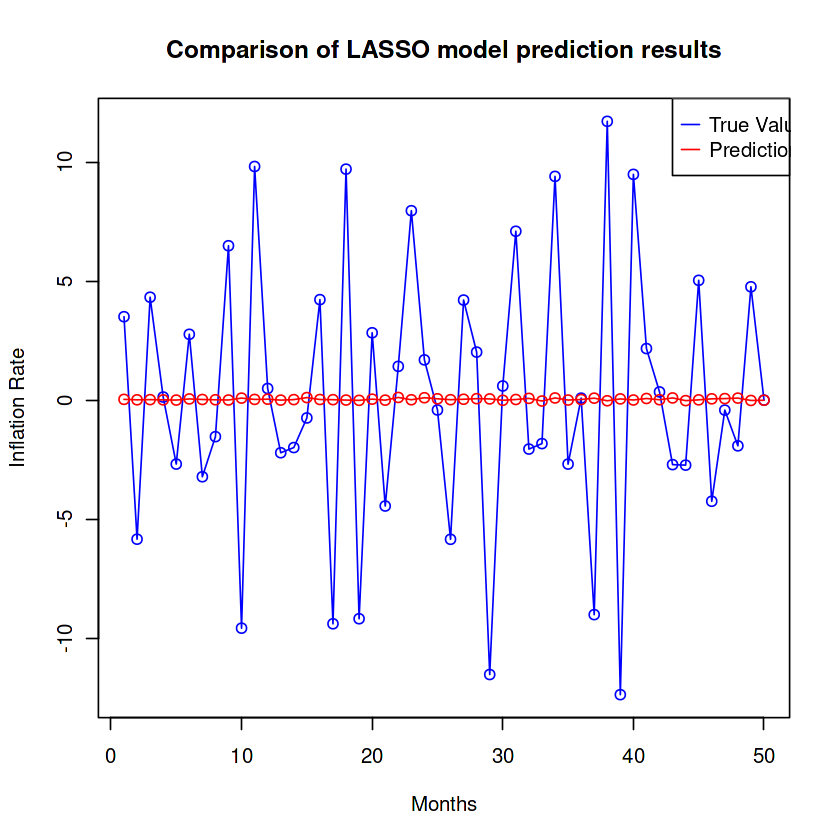

In [61]:
#在新数据中验证lasso
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优模型进行预测
predictions <- predict(best_lasso_model, s = best_lambda, newx = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse_Lasso <- mean((Y_test_sub - predictions)^2)
print(paste("均方误差为:", mse_Lasso))


## Evaluation of Lasso（3 months ahead）

In [62]:
# 加载LASSO模型
best_lasso_model_3months <- readRDS("best_lasso_model_3months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'best_lasso_model_3months.rds'.\n")


LASSO model loaded successfully from 'best_lasso_model_3months.rds'.


[1] "均方误差为: 32.206617190735"


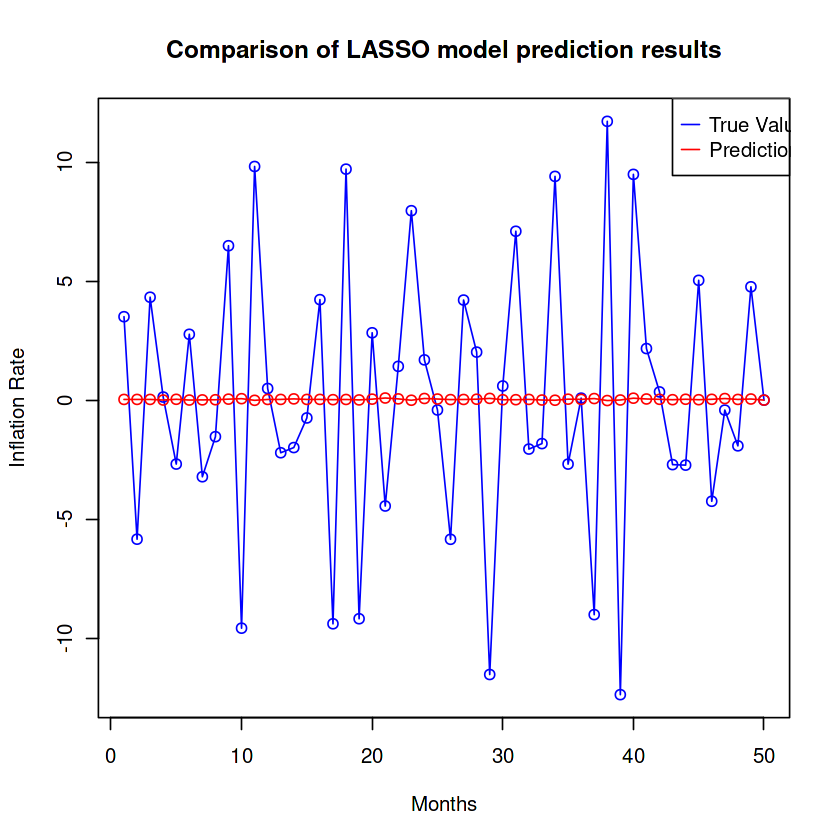

In [63]:
#在新数据中验证lasso，提前三个月
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优模型进行预测
predictions_3months <- predict(best_lasso_model_3months, s = best_lambda_3months, newx = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions_3months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse_Lasso_3months <- mean((Y_test_sub_3months - predictions_3months)^2)
print(paste("均方误差为:", mse_Lasso_3months))



## Evaluation of Lasso（1 year ahead）

In [64]:
# 加载LASSO模型
best_lasso_model_12months <- readRDS("best_lasso_model_12months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'best_lasso_model_12months.rds'.\n")


LASSO model loaded successfully from 'best_lasso_model_12months.rds'.


[1] "均方误差为: 32.2012854163499"


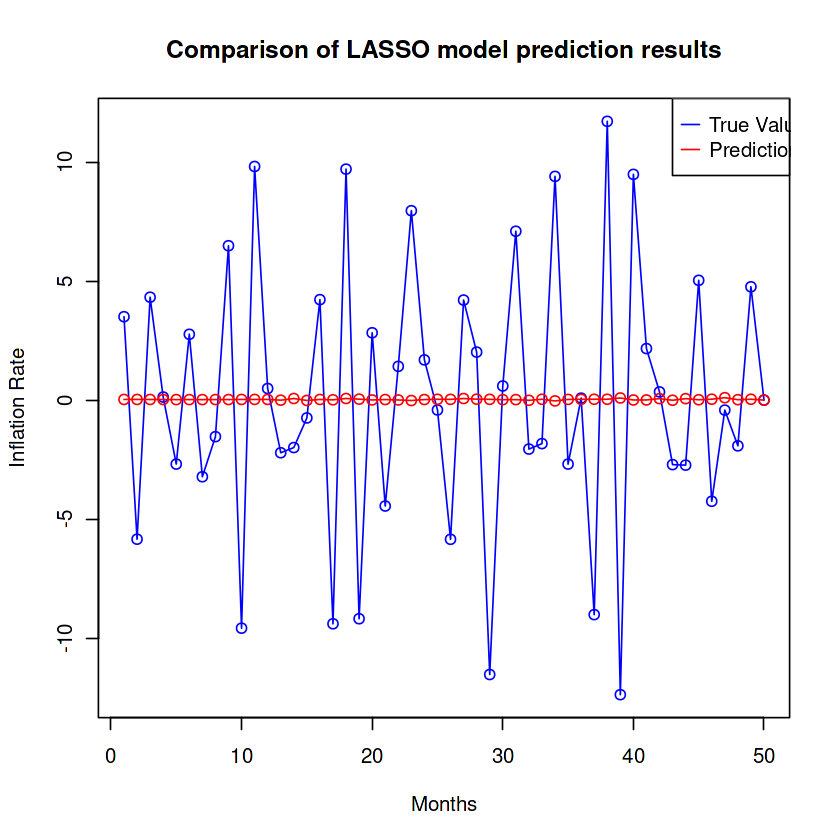

In [65]:
#在新数据中验证lasso，提前12个月
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优模型进行预测
predictions_12months <- predict(best_lasso_model_12months, s = best_lambda_12months, newx = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of LASSO model prediction results")
lines(predictions_12months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)


# 计算并打印预测的准确性指标，例如均方误差
mse_Lasso_12months <- mean((Y_test_sub_12months - predictions_12months)^2)
print(paste("均方误差为:", mse_Lasso_12months))

# Random Forest(1 months ahead)
## Modeling
### Load the required packages

In [66]:
if (!require(randomForest)) {
  install.packages("randomForest")
  library(randomForest)
}

# 可能还需要安装和加载ggplot2用于可视化
if (!require(ggplot2)) {
  install.packages("ggplot2")
  library(ggplot2)
}
if (!require(caret)) {
  install.packages("caret")
  library(caret)
}

if (!require(doParallel)) {
  install.packages("doParallel")
  library(doParallel)
}
if (!require(ranger)) {
  install.packages("ranger")
  library(ranger)
}

Random Forest 

  707 samples
11480 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 639, 635, 635, 635, 638, 635, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE        Rsquared   MAE       
    10   1             0.01858714  0.6141054  0.01378531
    10   5             0.01845520  0.6206991  0.01371783
    10  10             0.01855368  0.6161739  0.01379519
   100   1             0.01855310  0.6155660  0.01378038
   100   5             0.01863049  0.6130376  0.01386739
   100  10             0.01844018  0.6223313  0.01373909
   107   1             0.01844956  0.6201080  0.01381243
   107   5             0.01846073  0.6186468  0.01377288
   107  10             0.01860189  0.6123657  0.01384935
   115   1             0.01858588  0.6140508  0.01380086
   115   5             0.01854616  0.6155463  0.01377859
   115  10             0.01853378  0.6154751  0.01393203
   500   1             0.01838064  0.6210859  0.

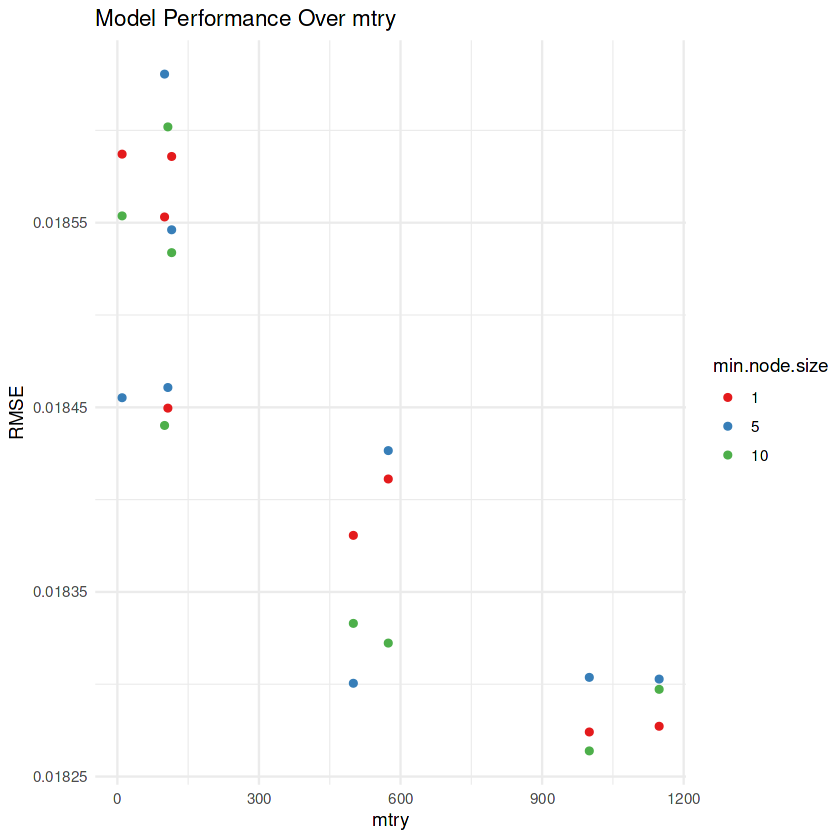

In [73]:
# 注册并行后台，设置使用的核心数
numCores <- parallel::detectCores()  # 检测可用的核心数
cl <- makeCluster(numCores - 1)  # 保留一个核心用于系统操作
registerDoParallel(cl)

# 设置训练控制，使用交叉验证
train_control <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的随机森林参数网格
tune_grid <- expand.grid(
  mtry = c(10, 100, 107, 115, 500, 574, 1000, 1148),  # 根据建议尝试的mtry值
  splitrule = c("variance"),  # 对回归任务常使用的分裂规则
  min.node.size = c(1, 5, 10)  # 最小节点大小
)

# 训练模型
rf_tuned_model <- train(
  x = X_scaled,
  y = Y,
  method = "ranger",  # 使用ranger包，对大数据集友好
  trControl = train_control,
  tuneGrid = tune_grid,
  metric = "RMSE",  # 使用均方根误差作为性能评估标准
  num.trees = 100  # 指定使用100棵树
)

# 停止并行后台
stopCluster(cl)
registerDoSEQ()  # 返回到单核运算

# 查看最佳模型的结果
print(rf_tuned_model)

# 绘制RMSE随mtry变化的图
performance_df <- rf_tuned_model$results

# 绘制模型性能图，不包含连线，点根据 min.node.size 区分颜色
ggplot(performance_df, aes(x = mtry, y = RMSE, color = factor(min.node.size))) +
  geom_point() +  # 只添加点，不添加线
  scale_color_brewer(palette = "Set1", name = "min.node.size") +  # 使用预定义的颜色板，并命名图例
  labs(title = "Model Performance Over mtry", x = "mtry", y = "RMSE") +
  theme_minimal()


In [74]:
# 保存LASSO模型到磁盘
saveRDS(rf_tuned_model, "rf_tuned_model.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'rf_tuned_model.rds'.\n")


LASSO model saved successfully to 'rf_tuned_model.rds'.


# Random Forest(3 months ahead)

Random Forest 

  705 samples
10660 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 636, 635, 635, 633, 634, 634, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE        Rsquared   MAE       
    10   1             0.01889112  0.6013314  0.01391456
    10   5             0.01892839  0.5993495  0.01407841
    10  10             0.01887333  0.6036421  0.01390076
   100   1             0.01887362  0.6011334  0.01403473
   100   5             0.01901813  0.5973166  0.01405472
   100  10             0.01887629  0.6035473  0.01395605
   107   1             0.01891659  0.6008310  0.01397689
   107   5             0.01884266  0.6074738  0.01393696
   107  10             0.01904113  0.5944788  0.01408544
   115   1             0.01898419  0.5984041  0.01402425
   115   5             0.01896431  0.5984646  0.01405813
   115  10             0.01896906  0.6008092  0.01404579
   500   1             0.01868019  0.6099274  0.

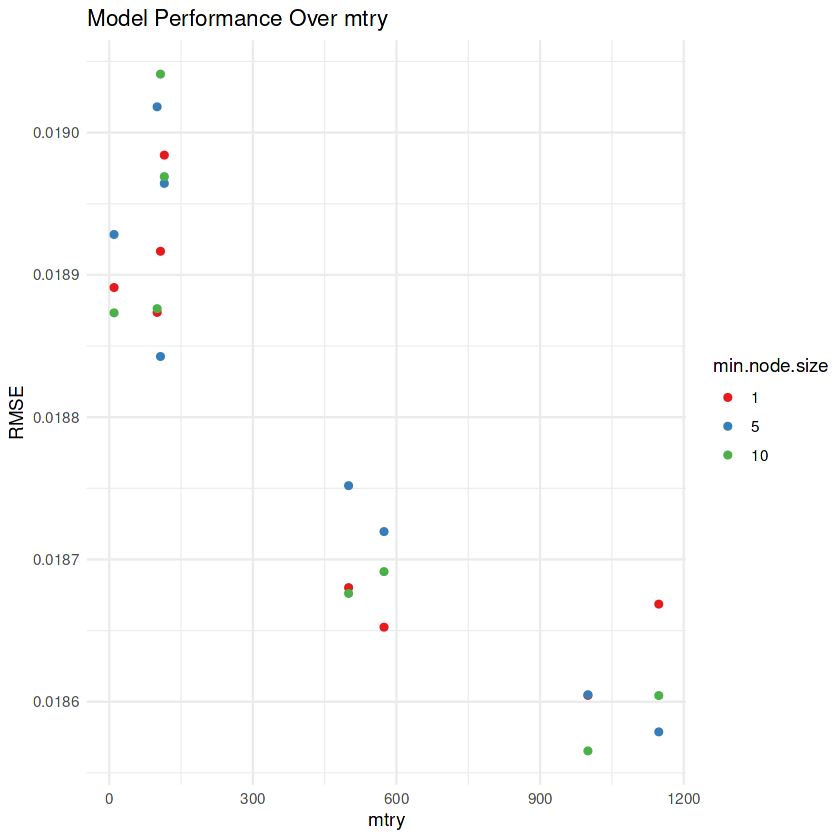

In [75]:
# 注册并行后台，设置使用的核心数
numCores <- parallel::detectCores()  # 检测可用的核心数
cl <- makeCluster(numCores - 1)  # 保留一个核心用于系统操作
registerDoParallel(cl)

# 设置训练控制，使用交叉验证
train_control <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的随机森林参数网格
tune_grid <- expand.grid(
  mtry = c(10, 100, 107, 115, 500, 574, 1000, 1148),  # 根据建议尝试的mtry值
  splitrule = c("variance"),  # 对回归任务常使用的分裂规则
  min.node.size = c(1, 5, 10)  # 最小节点大小
)

# 训练模型
rf_tuned_model_3months <- train(
  x = X_scaled_3months,
  y = Y_3months,
  method = "ranger",  # 使用ranger包，对大数据集友好
  trControl = train_control,
  tuneGrid = tune_grid,
  metric = "RMSE",  # 使用均方根误差作为性能评估标准
  num.trees = 100  # 指定使用100棵树
)

# 停止并行后台
stopCluster(cl)
registerDoSEQ()  # 返回到单核运算

# 查看最佳模型的结果
print(rf_tuned_model_3months)

# 绘制RMSE随mtry变化的图
performance_df_3months <- rf_tuned_model_3months$results

# 绘制模型性能图，不包含连线，点根据 min.node.size 区分颜色
ggplot(performance_df_3months, aes(x = mtry, y = RMSE, color = factor(min.node.size))) +
  geom_point() +  # 只添加点，不添加线
  scale_color_brewer(palette = "Set1", name = "min.node.size") +  # 使用预定义的颜色板，并命名图例
  labs(title = "Model Performance Over mtry", x = "mtry", y = "RMSE") +
  theme_minimal()


In [ ]:
# 保存LASSO模型到磁盘
saveRDS(rf_tuned_model_3months, "rf_tuned_model_3months.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'rf_tuned_model_3months.rds'.\n")

LASSO model saved successfully to 'rf_tuned_model_3months.rds'.


# Random Forest(1 year ahead)

Random Forest 

 696 samples
6970 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 626, 628, 626, 624, 627, 626, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE        Rsquared   MAE       
    10   1             0.01866382  0.6171645  0.01390626
    10   5             0.01876752  0.6118518  0.01379114
    10  10             0.01889292  0.6065922  0.01387375
   100   1             0.01899896  0.6042638  0.01391359
   100   5             0.01887796  0.6107908  0.01384645
   100  10             0.01893239  0.6069510  0.01392381
   107   1             0.01905649  0.6005246  0.01387780
   107   5             0.01887537  0.6082621  0.01390830
   107  10             0.01886650  0.6093227  0.01390088
   115   1             0.01902868  0.6012350  0.01409710
   115   5             0.01913309  0.5989316  0.01406427
   115  10             0.01906644  0.6021525  0.01410645
   500   1             0.01881300  0.6131490  0.01

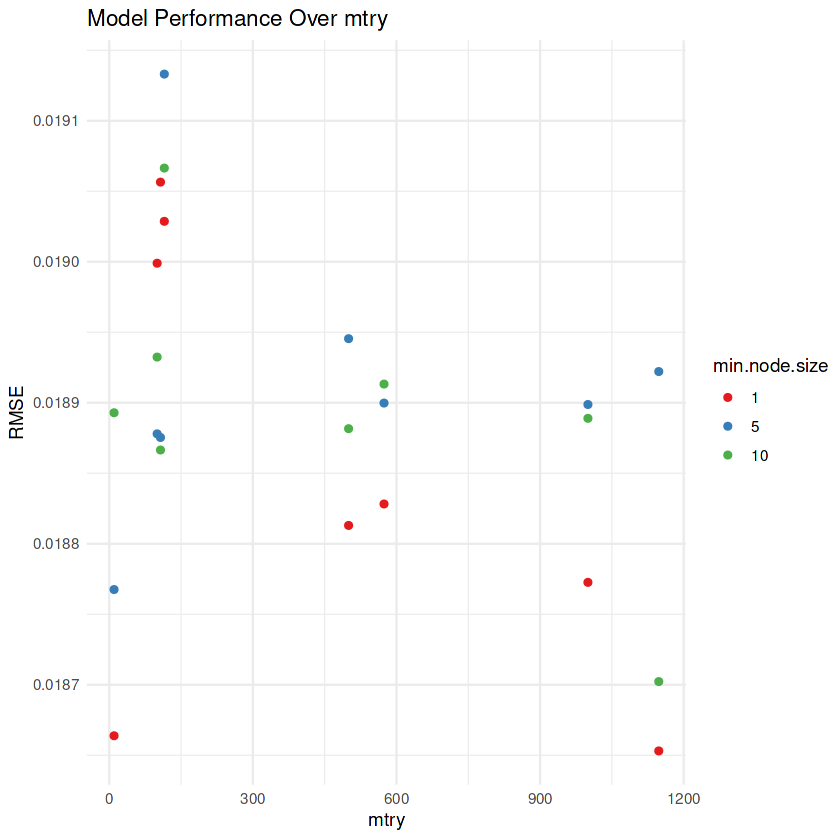

In [77]:


# 注册并行后台，设置使用的核心数
numCores <- parallel::detectCores()  # 检测可用的核心数
cl <- makeCluster(numCores - 1)  # 保留一个核心用于系统操作
registerDoParallel(cl)

# 设置训练控制，使用交叉验证
train_control <- trainControl(
  method = "cv",
  number = 10,
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的随机森林参数网格
tune_grid <- expand.grid(
  mtry = c(10, 100, 107, 115, 500, 574, 1000, 1148),  # 根据建议尝试的mtry值
  splitrule = c("variance"),  # 对回归任务常使用的分裂规则
  min.node.size = c(1, 5, 10)  # 最小节点大小
)

# 训练模型
rf_tuned_model_12months <- train(
  x = X_scaled_12months,
  y = Y_12months,
  method = "ranger",  # 使用ranger包，对大数据集友好
  trControl = train_control,
  tuneGrid = tune_grid,
  metric = "RMSE",  # 使用均方根误差作为性能评估标准
  num.trees = 100  # 指定使用100棵树
)

# 停止并行后台
stopCluster(cl)
registerDoSEQ()  # 返回到单核运算

# 查看最佳模型的结果
print(rf_tuned_model_12months)

# 绘制RMSE随mtry变化的图
performance_df_12months <- rf_tuned_model_12months$results

# 绘制模型性能图，不包含连线，点根据 min.node.size 区分颜色
ggplot(performance_df_12months, aes(x = mtry, y = RMSE, color = factor(min.node.size))) +
  geom_point() +  # 只添加点，不添加线
  scale_color_brewer(palette = "Set1", name = "min.node.size") +  # 使用预定义的颜色板，并命名图例
  labs(title = "Model Performance Over mtry", x = "mtry", y = "RMSE") +
  theme_minimal()


In [ ]:
# 保存LASSO模型到磁盘
saveRDS(rf_tuned_model_12months, "rf_tuned_model_12months.rds")

# 打印保存成功的消息
cat("LASSO model saved successfully to 'rf_tuned_model_12months.rds'.\n")

LASSO model saved successfully to 'rf_tuned_model_12months.rds'.


## Evaluation of Random Forest(1 month ahead)

In [79]:
# 加载LASSO模型
rf_tuned_model <- readRDS("rf_tuned_model.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model.rds'.\n")


LASSO model loaded successfully from 'rf_tuned_model.rds'.


[1] "均方误差为: 32.160831149051"


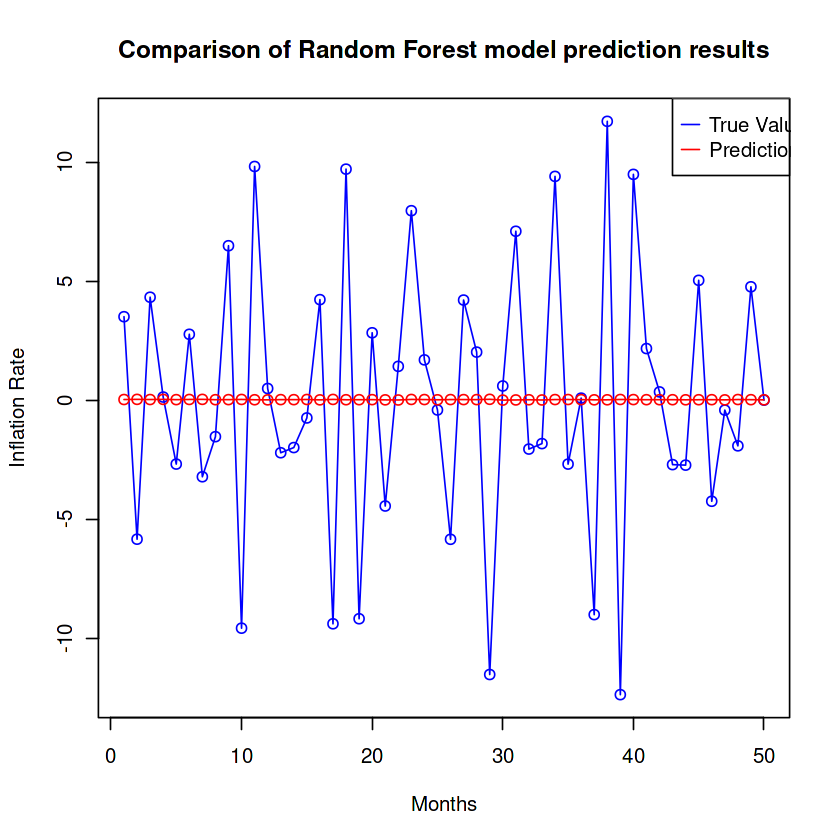

In [80]:
# 在新数据中验证随机森林模型
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优随机森林模型进行预测
predictions_rf <- predict(rf_tuned_model, newdata = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_rf, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_rf <- mean((Y_test_sub - predictions_rf)^2)
print(paste("均方误差为:", mse_rf))

## Evaluation of Random Forest(3 months ahead)

In [81]:
# 加载LASSO模型
rf_tuned_model_3months <- readRDS("rf_tuned_model_3months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model_3months.rds'.\n")

LASSO model loaded successfully from 'rf_tuned_model_3months.rds'.


[1] "均方误差为: 32.1490226501731"


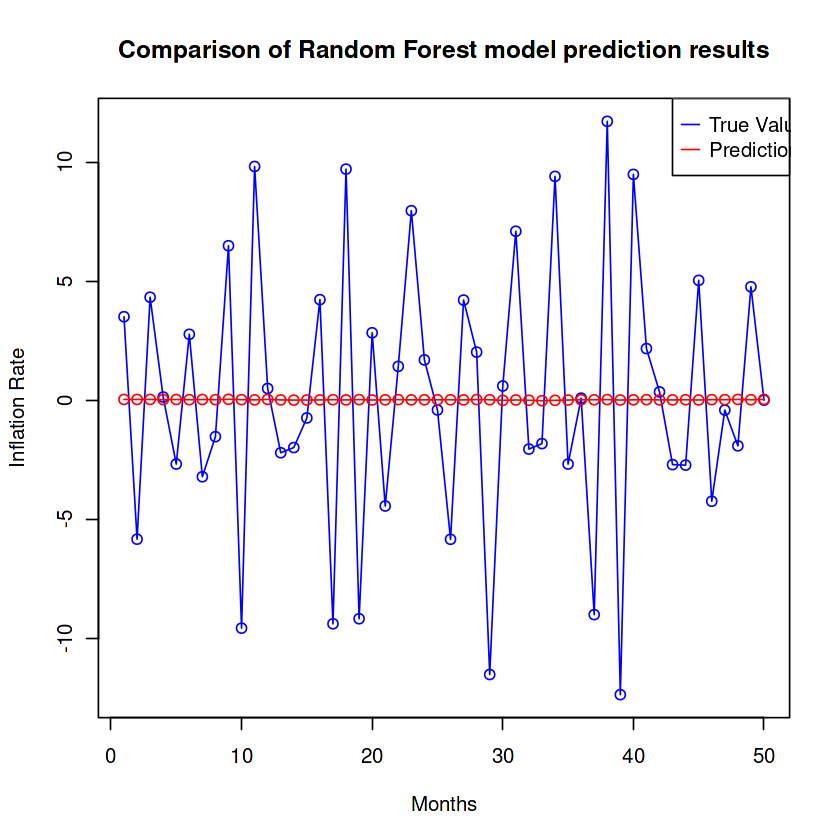

In [82]:
# 在新数据中验证随机森林模型，提前三个月
# 提取X_scaled_3months_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_3months_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优随机森林模型进行预测
predictions_3months <- predict(rf_tuned_model_3months, newdata = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_3months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_rf_3months <- mean((Y_test_sub_3months - predictions_3months)^2)
print(paste("均方误差为:", mse_rf_3months))

## Evaluation of Random Forest(1 year ahead)

In [83]:
# 加载LASSO模型
rf_tuned_model_12months <- readRDS("rf_tuned_model_12months.rds")

# 打印加载成功的消息
cat("LASSO model loaded successfully from 'rf_tuned_model_12months.rds'.\n")

LASSO model loaded successfully from 'rf_tuned_model_12months.rds'.


[1] "均方误差为: 32.1214384608771"


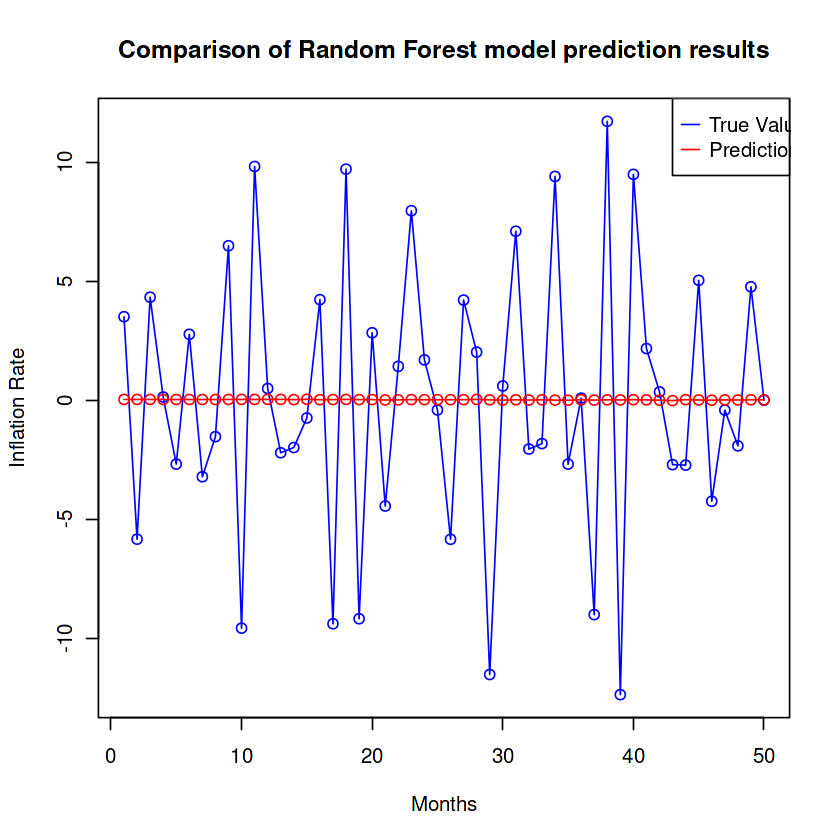

In [84]:
# 在新数据中验证随机森林模型，提前12个月
# 提取X_scaled_12months_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_12months_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优随机森林模型进行预测
predictions_12months <- predict(rf_tuned_model_12months, newdata = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of Random Forest model prediction results")
lines(predictions_12months, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_rf_12months <- mean((Y_test_sub_12months - predictions_12months)^2)
print(paste("均方误差为:", mse_rf_12months))




# Gradient Boosting(1 months ahead)
## Modeling
### Load the required packages

In [85]:
if (!require(caret)) {
  install.packages("caret")
  library(caret)
}
if (!require(doParallel)) {
  install.packages("doParallel")
  library(doParallel)
}
if (!require(gbm)) {
  install.packages("gbm")
  library(gbm)
}

Loading required package: gbm

Loaded gbm 2.1.8.1



Stochastic Gradient Boosting 

  707 samples
11480 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 637, 635, 636, 638, 637, 635, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  RMSE        Rsquared 
  0.001      1                  10              0.02868377  0.4837757
  0.001      1                  20              0.02868150  0.4851517
  0.001      3                  10              0.02834851  0.5784470
  0.001      3                  20              0.02835062  0.5717129
  0.001      5                  10              0.02825372  0.5941979
  0.001      5                  20              0.02827714  0.5828521
  0.005      1                  10              0.02547033  0.5127746
  0.005      1                  20              0.02545223  0.5129224
  0.005      3                  10              0.02420956  0.5847442
  0.005      3                  20              0.02420220  0.5826593
  0.

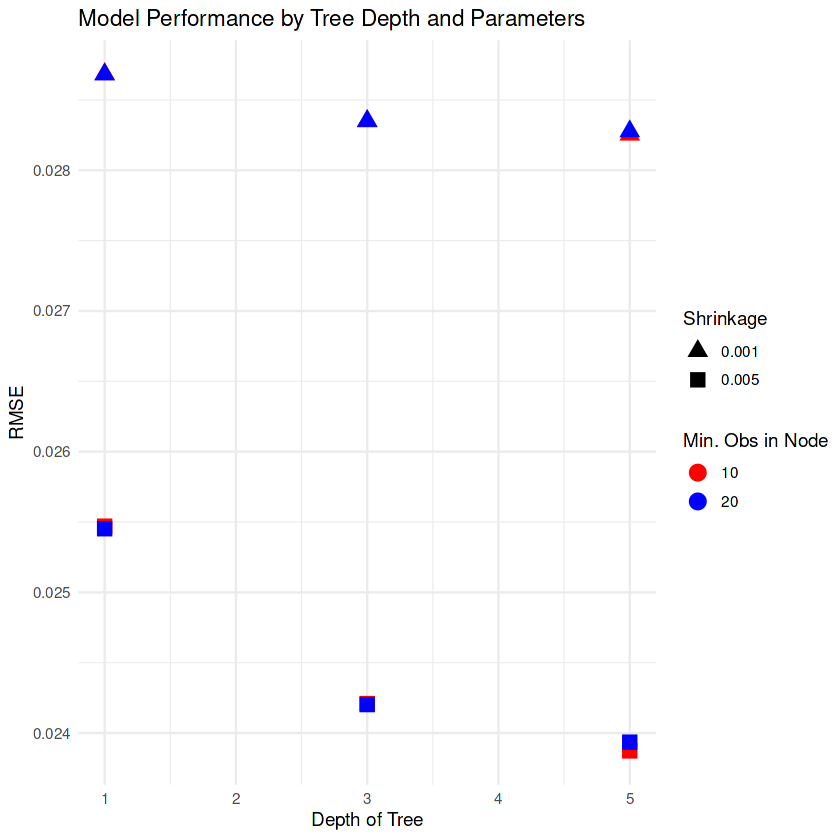

In [86]:
# 注册并行后台
numCores <- detectCores()
cl <- makeCluster(numCores - 1)  # 保留一个核心
registerDoParallel(cl)

# 设置训练控制
train_control <- trainControl(
  method = "cv",  # 使用交叉验证
  number = 10,    # 10折交叉验证
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的梯度提升模型参数网格
tune_grid <- expand.grid(
  interaction.depth = c(1, 3, 5),
  n.minobsinnode = c(10, 20),
  shrinkage = c(0.001, 0.005),
  n.trees = 100  # 固定树的数量为100
)

# 训练梯度提升模型
gbm_model <- train(
  x = X_scaled, 
  y = Y, 
  method = "gbm", 
  tuneGrid = tune_grid,
  trControl = train_control,
  verbose = FALSE
)

# 关闭并行处理
stopCluster(cl)
registerDoSEQ()

# 打印模型输出
print(gbm_model)

# 可视化模型的性能
results <- gbm_model$results
plot <- ggplot(results, aes(x = interaction.depth, y = RMSE, color = factor(n.minobsinnode), shape = factor(shrinkage))) +
  geom_point(size = 4) +
  scale_color_manual(values = c("red", "blue"), labels = c("10", "20")) +
  scale_shape_manual(values = c(17, 15), labels = c("0.001", "0.005")) +
  labs(
    x = "Depth of Tree",
    y = "RMSE",
    title = "Model Performance by Tree Depth and Parameters",
    color = "Min. Obs in Node",
    shape = "Shrinkage"
  ) +
  theme_minimal()

# 显示图
print(plot)


In [87]:
# 保存模型到磁盘
saveRDS(gbm_model, "gbm_model.rds")

# 打印保存成功的消息
cat("Model saved successfully to 'gbm_model.rds'.\n")


Model saved successfully to 'gbm_model.rds'.


# Gradient Boosting(3 months ahead)

In [90]:

# 注册并行后台
numCores <- detectCores()
cl <- makeCluster(numCores - 1)  # 保留一个核心
registerDoParallel(cl)

# 设置训练控制
train_control <- trainControl(
  method = "cv",  # 使用交叉验证
  number = 10,    # 10折交叉验证
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的梯度提升模型参数网格
tune_grid <- expand.grid(
  interaction.depth = c(1, 3, 5),
  n.minobsinnode = c(10, 20),
  shrinkage = c(0.001, 0.005),
  n.trees = 100  # 固定树的数量为100
)

# 训练梯度提升模型
gbm_model_3months <- train(
  x = X_scaled_3months, 
  y = Y_3months, 
  method = "gbm", 
  tuneGrid = tune_grid,
  trControl = train_control,
  verbose = FALSE
)

# 关闭并行处理
stopCluster(cl)
registerDoSEQ()


Stochastic Gradient Boosting 

  705 samples
10660 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 633, 633, 636, 636, 636, 635, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  RMSE        Rsquared 
  0.001      1                  10              0.02861962  0.4658003
  0.001      1                  20              0.02861873  0.4699679
  0.001      3                  10              0.02831542  0.5563673
  0.001      3                  20              0.02831757  0.5530470
  0.001      5                  10              0.02825330  0.5676389
  0.001      5                  20              0.02825437  0.5639262
  0.005      1                  10              0.02540835  0.4972945
  0.005      1                  20              0.02543182  0.4989969
  0.005      3                  10              0.02426333  0.5551730
  0.005      3                  20              0.02429267  0.5580317
  0.

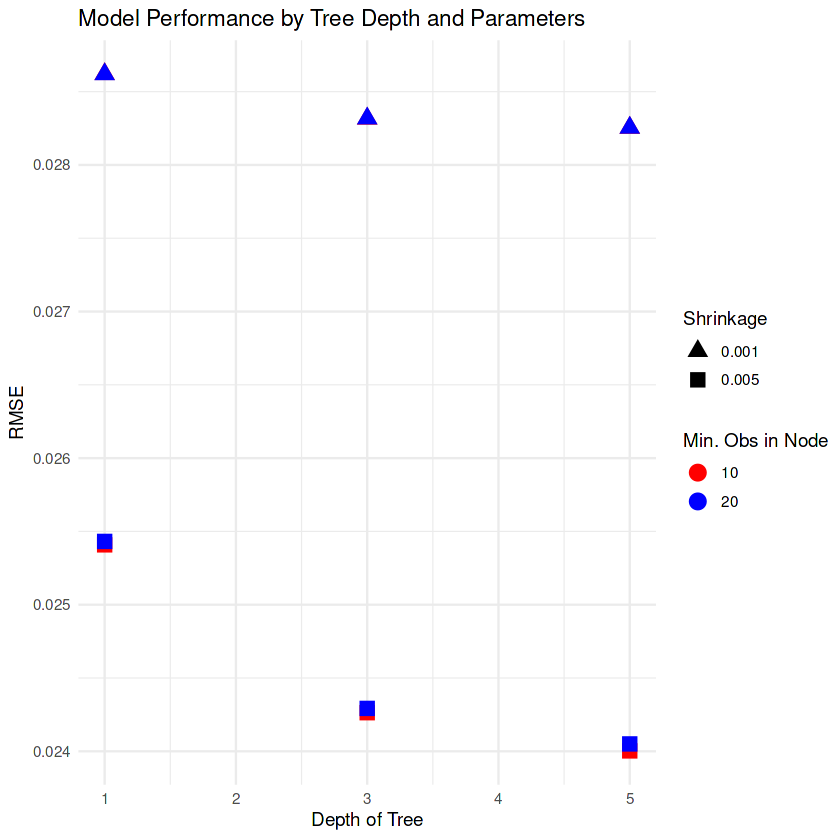

In [99]:
# 打印模型输出
print(gbm_model_3months)

# 可视化模型的性能
results_3months <- gbm_model_3months$results
plot_3months <- ggplot(results_3months, aes(x = interaction.depth, y = RMSE, color = factor(n.minobsinnode), shape = factor(shrinkage))) +
  geom_point(size = 4) +
  scale_color_manual(values = c("red", "blue"), labels = c("10", "20")) +
  scale_shape_manual(values = c(17, 15), labels = c("0.001", "0.005")) +
  labs(
    x = "Depth of Tree",
    y = "RMSE",
    title = "Model Performance by Tree Depth and Parameters",
    color = "Min. Obs in Node",
    shape = "Shrinkage"
  ) +
  theme_minimal()

# 显示图
print(plot_3months)


In [ ]:
# 保存模型到磁盘
saveRDS(gbm_model_3months, "gbm_model_3months.rds")

# 打印保存成功的消息
cat("Model saved successfully to 'gbm_model_3months.rds'.\n")


# Gradient Boosting(1 year ahead)

Stochastic Gradient Boosting 

 696 samples
6970 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 625, 628, 627, 625, 626, 627, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  RMSE        Rsquared 
  0.001      1                  10              0.02854689  0.4368519
  0.001      1                  20              0.02854210  0.4417541
  0.001      3                  10              0.02823559  0.5417096
  0.001      3                  20              0.02822039  0.5511895
  0.001      5                  10              0.02816808  0.5590948
  0.001      5                  20              0.02815584  0.5663513
  0.005      1                  10              0.02554239  0.4704164
  0.005      1                  20              0.02557655  0.4633188
  0.005      3                  10              0.02437727  0.5530648
  0.005      3                  20              0.02430094  0.5592459
  0.00

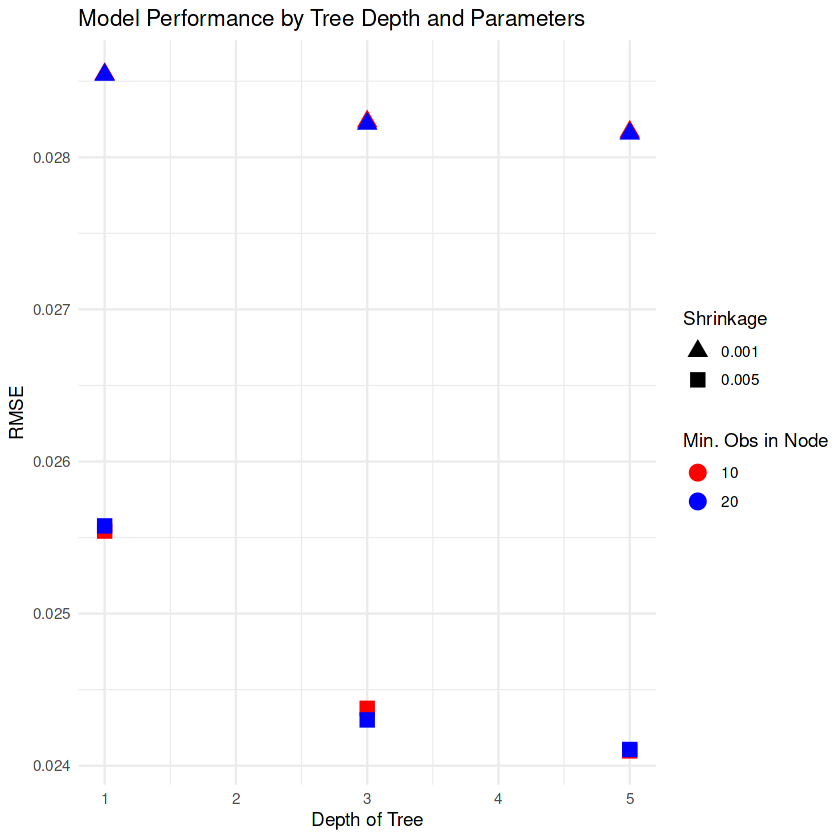

In [91]:
# 注册并行后台
numCores <- detectCores()
cl <- makeCluster(numCores - 1)  # 保留一个核心
registerDoParallel(cl)

# 设置训练控制
train_control <- trainControl(
  method = "cv",  # 使用交叉验证
  number = 10,    # 10折交叉验证
  allowParallel = TRUE  # 允许并行计算
)

# 定义要尝试的梯度提升模型参数网格
tune_grid <- expand.grid(
  interaction.depth = c(1, 3, 5),
  n.minobsinnode = c(10, 20),
  shrinkage = c(0.001, 0.005),
  n.trees = 100  # 固定树的数量为100
)

# 训练梯度提升模型
gbm_model_12months <- train(
  x = X_scaled_12months, 
  y = Y_12months, 
  method = "gbm", 
  tuneGrid = tune_grid,
  trControl = train_control,
  verbose = FALSE
)

# 关闭并行处理
stopCluster(cl)
registerDoSEQ()

# 打印模型输出
print(gbm_model_12months)

# 可视化模型的性能
results_12months <- gbm_model_12months$results
plot_12months <- ggplot(results_12months, aes(x = interaction.depth, y = RMSE, color = factor(n.minobsinnode), shape = factor(shrinkage))) +
  geom_point(size = 4) +
  scale_color_manual(values = c("red", "blue"), labels = c("10", "20")) +
  scale_shape_manual(values = c(17, 15), labels = c("0.001", "0.005")) +
  labs(
    x = "Depth of Tree",
    y = "RMSE",
    title = "Model Performance by Tree Depth and Parameters",
    color = "Min. Obs in Node",
    shape = "Shrinkage"
  ) +
  theme_minimal()

# 显示图
print(plot_12months)

In [92]:
# 保存模型到磁盘
saveRDS(gbm_model_12months, "gbm_model_12months.rds")

# 打印保存成功的消息
cat("Model saved successfully to 'gbm_model_12months.rds'.\n")


Model saved successfully to 'gbm_model_12months.rds'.


## Evaluation of GBM (1 month ahead)

In [93]:
# 加载模型
gbm_model <- readRDS("gbm_model.rds")

# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model.rds'.\n")


Model loaded successfully from 'gbm_model.rds'.


[1] "均方误差为: 32.1476185013068"


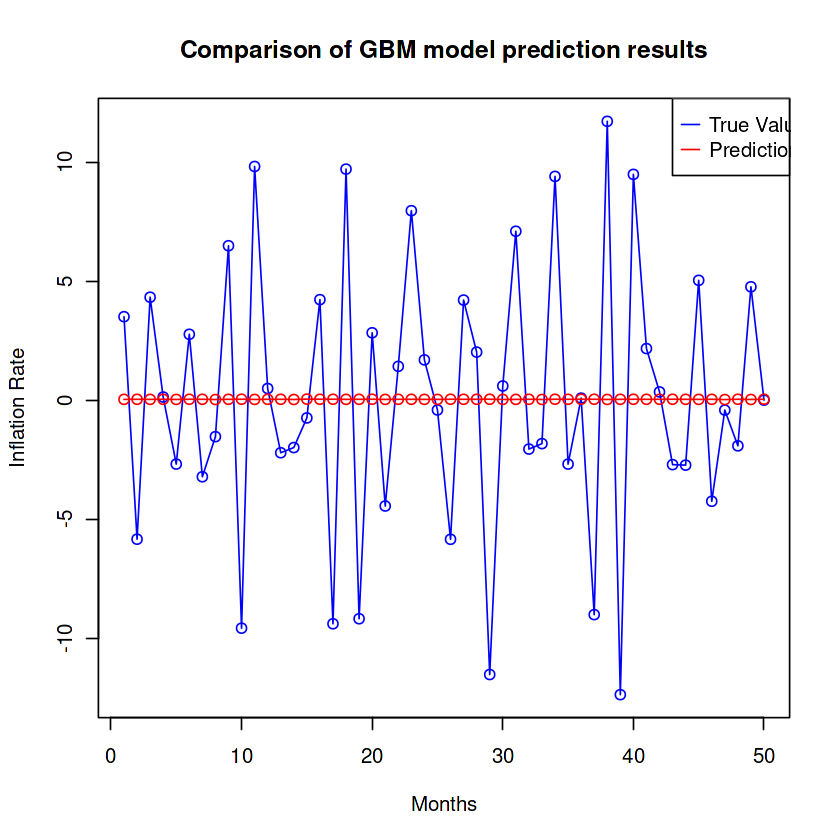

In [94]:
# 在新数据中验证GBM模型
# 提取X_scaled_test的后50行作为新的测试数据
X_test_sub <- X_scaled_test[(nrow(X_scaled_test)-49):nrow(X_scaled_test), ]

# 提取Y_test的后50行作为新的目标数据
Y_test_sub <- Y_test[(length(Y_test)-49):length(Y_test)]

# 使用最优GBM模型进行预测
predictions_gbm <- predict(gbm_model, newdata = X_test_sub)

# 可视化实际值与预测值
plot(Y_test_sub, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM model prediction results")
lines(predictions_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_gbm <- mean((Y_test_sub - predictions_gbm)^2)
print(paste("均方误差为:", mse_gbm))

## Evaluation of GBM (3 months ahead)

In [95]:
# 加载模型
gbm_model_3months <- readRDS("gbm_model_3months.rds")

# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model_3months.rds'.\n")


Model loaded successfully from 'gbm_model_3months.rds'.


[1] "均方误差为: 32.1458966126571"


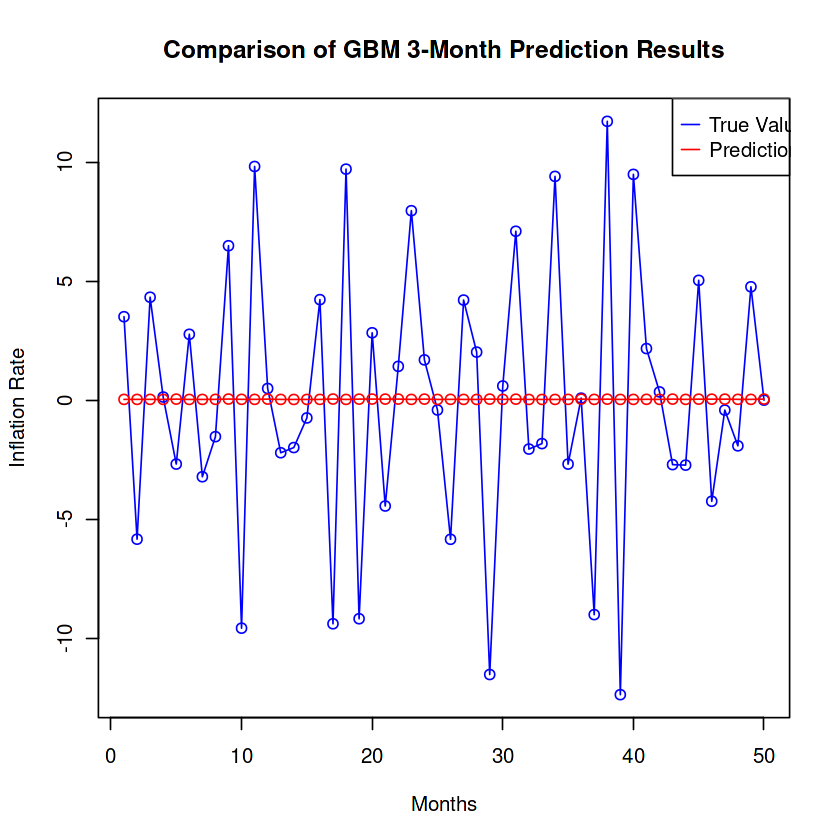

In [96]:
# 在新数据中验证GBM模型，预测未来3个月
# 提取X_scaled_3months_test的后50行作为新的测试数据
X_test_sub_3months <- X_scaled_3months_test[(nrow(X_scaled_3months_test)-49):nrow(X_scaled_3months_test), ]

# 提取Y_3months_test的后50行作为新的目标数据
Y_test_sub_3months <- Y_3months_test[(length(Y_3months_test)-49):length(Y_3months_test)]

# 使用最优GBM模型进行预测
predictions_3months_gbm <- predict(gbm_model_3months, newdata = X_test_sub_3months)

# 可视化实际值与预测值
plot(Y_test_sub_3months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM 3-Month Prediction Results")
lines(predictions_3months_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_3months_gbm <- mean((Y_test_sub_3months - predictions_3months_gbm)^2)
print(paste("均方误差为:", mse_3months_gbm))


## Evaluation of GBM (1 year ahead)

In [97]:
# 加载模型
gbm_model_12months <- readRDS("gbm_model_12months.rds")

# 打印加载成功的消息
cat("Model loaded successfully from 'gbm_model_12months.rds'.\n")


Model loaded successfully from 'gbm_model_12months.rds'.


[1] "均方误差为: 32.1445325868197"


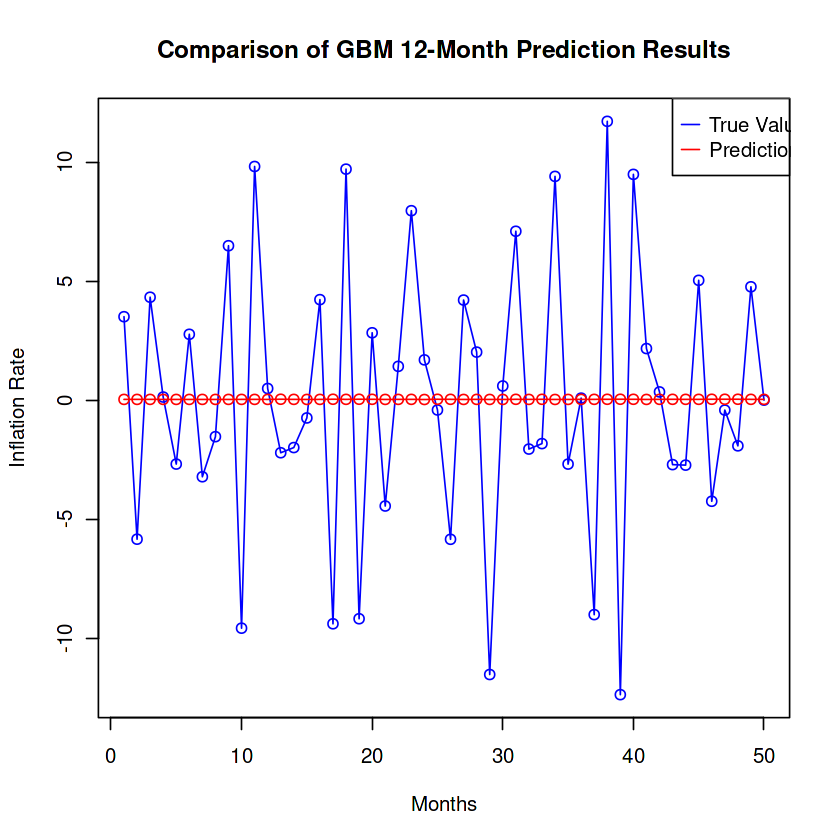

In [98]:
# 在新数据中验证GBM模型，预测未来12个月
# 提取X_scaled_12months_test的后50行作为新的测试数据
X_test_sub_12months <- X_scaled_12months_test[(nrow(X_scaled_12months_test)-49):nrow(X_scaled_12months_test), ]

# 提取Y_12months_test的后50行作为新的目标数据
Y_test_sub_12months <- Y_12months_test[(length(Y_12months_test)-49):length(Y_12months_test)]

# 使用最优GBM模型进行预测
predictions_12months_gbm <- predict(gbm_model_12months, newdata = X_test_sub_12months)

# 可视化实际值与预测值
plot(Y_test_sub_12months, type = "o", col = "blue", xlab = "Months", ylab = "Inflation Rate", main = "Comparison of GBM 12-Month Prediction Results")
lines(predictions_12months_gbm, type = "o", col = "red")
legend("topright", legend = c("True Value", "Prediction Value"), col = c("blue", "red"), lty = 1)

# 计算并打印预测的准确性指标，例如均方误差
mse_12months_gbm <- mean((Y_test_sub_12months - predictions_12months_gbm)^2)
print(paste("均方误差为:", mse_12months_gbm))
